In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

organizations_uciml_electric_power_consumption_data_set_path = kagglehub.dataset_download('organizations/uciml/electric-power-consumption-data-set')
nazmclk_data_to_model_path = kagglehub.dataset_download('nazmclk/data-to-model')

print('Data source import complete.')


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<u><p style="font-size: 36px;font-weight: bold;font-style: oblique;text-indent: 30px;text-align: center;">**Household Electric Power Consumption Forecasting**</p></u>
<p style="text-indent:30px;font-size:16px"> The real energy demand made on the present electrical supply is referred to as electric energy consumption. However, poor management of its use can result in a reduction in electrical supply. As a result, it is critical that everyone be concerned about energy efficiency in order to reduce consumption. The goals of this study are to develop a model for <strong>forecasting household electricity usage</strong> and to determine the best forecasting period, which could be daily, weekly, monthly, or quarterly. Individual household electricity power usage is the time-series data in our investigation.This Notebook use Deep Learning and time-series data analysis methods for this aim.<br></p>
<p style="text-indent:30px;font-size:16px;">Any household requires electricity to function. In this period of global instability, the globe requires rising amounts of energy to maintain economic and social progress and improve living standards. Mishandling of electric energy could result in future excessive costs. Over 60% of residential energy in the United States is wasted. Many people who use power on a regular basis are unaware of how much energy is wasted. In this notebook series, I want to use and compare some of the following DeepLearning models: <strong>Prophet – Facebook, ARIMA (Autoregressive Integrated Moving Average), XGBoost/LightGBM, LSTM (Long Short Term Memory), DeepAR (Amazon time series model) and transformer(TFT,PatchTST,ETSformer,FEDformer) mentioned in link below and N-Beats, N-HITS are also mentioned in the timeseries interested community.</strong><p/>
    
["https://github.com/thuml/Time-Series-Library"](http://github.com/thuml/Time-Series-Library)

## ***About Dataset And Features:***

#### A detailed description of the dataset is given in the notebook, which is the first of this notebook series, and in the original location of the dataset on Kaggle.

## ***1.Importing Libraries***

In [2]:
# Let`s import all packages that we may need:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from pandas.tseries.frequencies import to_offset

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # To simplify TensorFlow logs

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## ***2.Reading Data***

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Household_Electric_Consumption/df_before_modeling.csv',sep=',',
                 infer_datetime_format=True,
                 low_memory=False, index_col='dt')

In [4]:
df.index = pd.to_datetime(df.index)

In [5]:
df.head()

voltage  global_intensity  sub_metering_1  \
dt                                                               
2006-12-16 17:24:00   234.84              18.4             0.0   
2006-12-16 17:25:00   233.63              23.0             0.0   
2006-12-16 17:26:00   233.29              23.0             0.0   
2006-12-16 17:27:00   233.74              23.0             0.0   
2006-12-16 17:28:00   235.68              15.8             0.0   

                     sub_metering_2  sub_metering_3  power_factor  
dt                                                                 
2006-12-16 17:24:00             1.0            17.0      0.995121  
2006-12-16 17:25:00             1.0            16.0      0.996708  
2006-12-16 17:26:00             2.0            17.0      0.995734  
2006-12-16 17:27:00             1.0            17.0      0.995688  
2006-12-16 17:28:00             1.0            17.0      0.989787

## ***3.MODELING***

### ***3.1. Model Preparation***

In [ ]:
df_hourly = df.resample("H").mean()

In [ ]:
df_hourly.shape

(34589, 6)

In [ ]:
df_hourly.head()

voltage  global_intensity  sub_metering_1  \
dt                                                                  
2006-12-16 17:00:00  234.643889         18.100000             0.0   
2006-12-16 18:00:00  234.580167         15.600000             0.0   
2006-12-16 19:00:00  233.232500         14.503333             0.0   
2006-12-16 20:00:00  234.071500         13.916667             0.0   
2006-12-16 21:00:00  237.158667         13.046667             0.0   

                     sub_metering_2  sub_metering_3  power_factor  
dt                                                                 
2006-12-16 17:00:00        0.527778       16.861111      0.997052  
2006-12-16 18:00:00        6.716667       16.866667      0.999518  
2006-12-16 19:00:00        1.433333       16.683333      0.999526  
2006-12-16 20:00:00        0.000000       16.783333      0.999569  
2006-12-16 21:00:00        0.416667       17.216667      0.999422

In [ ]:
import numpy as np

def create_sequences(data, n_steps):
    """
    Creates sequences from time series data for LSTM/GRU model input.

    Parameters:
    -----------
    data : numpy array
        Input data with shape (samples, features).
        The last column is assumed to be the target variable.
    n_steps : int
        Number of time steps to look back (sequence length)

    Returns:
    --------
    X : numpy array
        Sequences with shape (samples, timesteps, features)
    y : numpy array
        Target values with shape (samples,)

    Example:
    --------
    # Assuming 'data' is your numpy array with shape (1000, 5)
    # where last column is your target variable
    X, y = create_sequences(data, n_steps=30)
    """
    X, y = [], []
    for i in range(len(data) - n_steps):
        sequence = data[i:(i + n_steps), :]
        target = data[i + n_steps, -1]  # Last column as target
        X.append(sequence)
        y.append(target)

    return np.array(X), np.array(y)

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
original_columns = df_hourly.columns.tolist()

# Data preprocessing
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_hourly.reset_index(drop=True))
df_scaled = pd.DataFrame(df_scaled, columns=df_hourly.columns, index=df_hourly.index)
df_scaled['Datetime'] = df_hourly.index
df_scaled.set_index('Datetime', inplace=True)

In [ ]:
df_scaled.head(3)

voltage  global_intensity  sub_metering_1  \
Datetime                                                          
2006-12-16 17:00:00 -2.077988          3.607876       -0.319086   
2006-12-16 18:00:00 -2.099360          2.938368       -0.319086   
2006-12-16 19:00:00 -2.551344          2.644677       -0.319086   

                     sub_metering_2  sub_metering_3  power_factor  
Datetime                                                           
2006-12-16 17:00:00       -0.184969        1.424259      0.811481  
2006-12-16 18:00:00        1.300378        1.425020      0.872132  
2006-12-16 19:00:00        0.032366        1.399919      0.872329

In [ ]:
# Train-test split
train_df = df_scaled.loc[df_scaled.index < '2010-01-01 00:00:00']
test_df = df_scaled.loc[df_scaled.index >= '2010-01-01 00:00:00']

target_col = 'power_factor'
feature_cols = train_df.columns.drop([target_col])

# Prepare data for LSTM
X_train_raw = train_df[feature_cols].values
y_train_raw = train_df[target_col].values
X_test_raw = test_df[feature_cols].values
y_test_raw = test_df[target_col].values

In [ ]:
df_scaled.head(3)

voltage  global_intensity  sub_metering_1  \
Datetime                                                          
2006-12-16 17:00:00 -2.077988          3.607876       -0.319086   
2006-12-16 18:00:00 -2.099360          2.938368       -0.319086   
2006-12-16 19:00:00 -2.551344          2.644677       -0.319086   

                     sub_metering_2  sub_metering_3  power_factor  
Datetime                                                           
2006-12-16 17:00:00       -0.184969        1.424259      0.811481  
2006-12-16 18:00:00        1.300378        1.425020      0.872132  
2006-12-16 19:00:00        0.032366        1.399919      0.872329

In [ ]:
train_df.head(3)

voltage  global_intensity  sub_metering_1  \
Datetime                                                          
2006-12-16 17:00:00 -2.077988          3.607876       -0.319086   
2006-12-16 18:00:00 -2.099360          2.938368       -0.319086   
2006-12-16 19:00:00 -2.551344          2.644677       -0.319086   

                     sub_metering_2  sub_metering_3  power_factor  
Datetime                                                           
2006-12-16 17:00:00       -0.184969        1.424259      0.811481  
2006-12-16 18:00:00        1.300378        1.425020      0.872132  
2006-12-16 19:00:00        0.032366        1.399919      0.872329

In [ ]:
train_df.tail(3)

voltage  global_intensity  sub_metering_1  \
Datetime                                                          
2009-12-31 21:00:00 -1.408023          2.001056       -0.319086   
2009-12-31 22:00:00 -0.981304          1.042320       -0.319086   
2009-12-31 23:00:00 -0.257716          0.623654       -0.319086   

                     sub_metering_2  sub_metering_3  power_factor  
Datetime                                                           
2009-12-31 21:00:00       -0.227636        1.678307      0.805964  
2009-12-31 22:00:00       -0.183636        1.577905      0.795738  
2009-12-31 23:00:00       -0.311637        1.623542      0.809150

In [ ]:
test_df.head(3)

voltage  global_intensity  sub_metering_1  \
Datetime                                                          
2010-01-01 00:00:00  0.154358         -0.040499       -0.319086   
2010-01-01 01:00:00  0.261905         -0.510047       -0.319086   
2010-01-01 02:00:00  1.064029         -0.528794       -0.319086   

                     sub_metering_2  sub_metering_3  power_factor  
Datetime                                                           
2010-01-01 00:00:00       -0.311637        0.281803      0.628644  
2010-01-01 01:00:00       -0.119635       -0.795239      0.188649  
2010-01-01 02:00:00       -0.311637       -0.792957      0.429025

In [ ]:
test_df.tail(3)

voltage  global_intensity  sub_metering_1  \
Datetime                                                          
2010-11-26 19:00:00 -1.374653          0.650434       -0.319086   
2010-11-26 20:00:00 -0.484211          0.076442       -0.319086   
2010-11-26 21:00:00 -0.385608         -0.221712       -0.319086   

                     sub_metering_2  sub_metering_3  power_factor  
Datetime                                                           
2010-11-26 19:00:00       -0.295637       -0.884232      0.852165  
2010-11-26 20:00:00       -0.055635       -0.884232      0.814536  
2010-11-26 21:00:00       -0.311637       -0.884232      0.883997

### ***3.2.Model Selection¶***
#### ***3.2.1.LSTM(Long Short Term Memory)***


LSTM (Long Short-Term Memory) is a special type of RNN (Recurrent Neural Network) designed for sequential data problems such as time series forecasting, natural language processing (NLP), and speech recognition.<br>

 Why LSTM?<br><br>

- Can learn both short-term and long-term dependencies <br>
- Solves the Vanishing Gradient problem <br>
- Stores past information for a long time using memory cells <br><br>
 Key Components of LSTM<br><br>
LSTM consists of three main gates:<br>

- Forget Gate: Deletes unnecessary information.<br>
- Input Gate: Adds new information to memory.<br>
- Output Gate: Outputs the updated information.<br><br>
 Applications of LSTM<br><br>

- Time Series Forecasting (Finance, weather, energy demand prediction)<br>
- Natural Language Processing (NLP) (Text prediction, translation, chatbots)<br>
- Speech and Voice Recognition<br>
- Medical Data Analysis

Epoch 1/10
417/417 - 5s - 11ms/step - loss: 0.5721 - mean_absolute_error: 0.5992 - val_loss: 0.5413 - val_mean_absolute_error: 0.5742
Epoch 2/10
417/417 - 2s - 4ms/step - loss: 0.4818 - mean_absolute_error: 0.5255 - val_loss: 0.5093 - val_mean_absolute_error: 0.5265
Epoch 3/10
417/417 - 2s - 4ms/step - loss: 0.4638 - mean_absolute_error: 0.5073 - val_loss: 0.4934 - val_mean_absolute_error: 0.5058
Epoch 4/10
417/417 - 2s - 4ms/step - loss: 0.4521 - mean_absolute_error: 0.4969 - val_loss: 0.4790 - val_mean_absolute_error: 0.4993
Epoch 5/10
417/417 - 2s - 4ms/step - loss: 0.4419 - mean_absolute_error: 0.4893 - val_loss: 0.4717 - val_mean_absolute_error: 0.4956
Epoch 6/10
417/417 - 2s - 4ms/step - loss: 0.4318 - mean_absolute_error: 0.4805 - val_loss: 0.4670 - val_mean_absolute_error: 0.4961
Epoch 7/10
417/417 - 2s - 5ms/step - loss: 0.4245 - mean_absolute_error: 0.4748 - val_loss: 0.4561 - val_mean_absolute_error: 0.4887
Epoch 8/10
417/417 - 2s - 4ms/step - loss: 0.4150 - mean_absolute_er

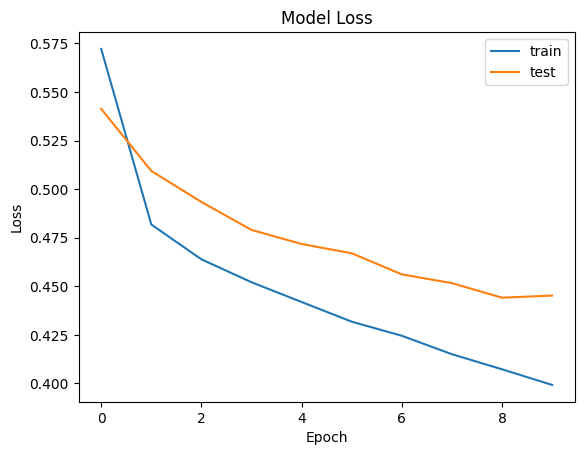

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
inv_y shape: (7888,)
inv_yhat shape: (7888,)
Test MAPE: 2.013%
Test RMSE: 0.027


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Create sequences for LSTM
n_steps = 30
X_train, y_train = create_sequences(np.column_stack((y_train_raw, X_train_raw)), n_steps)
X_test, y_test = create_sequences(np.column_stack((y_test_raw, X_test_raw)), n_steps)

# Create the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, activation='tanh',
                   input_shape=(n_steps, X_train.shape[2]),
                   return_sequences=False))
model_lstm.add(Dense(1))

# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.001),
                  loss="mean_squared_error",
                  metrics=['mean_absolute_error'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                             patience=10,
                             restore_best_weights=True)

# Train the model
history_lstm = model_lstm.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    verbose=2,
    shuffle=False,
    callbacks=[early_stopping]
)

# Plot training history
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Make predictions
yhat = model_lstm.predict(X_test)

# Ensure the predicted values and test values have the same length
yhat = yhat.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(yhat), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = yhat

# Inverse transform using the original scaler
inv_yhat = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_yhat.shape)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100

print('Test MAPE: %.3f%%' % mape)
print('Test RMSE: %.3f' % rmse)

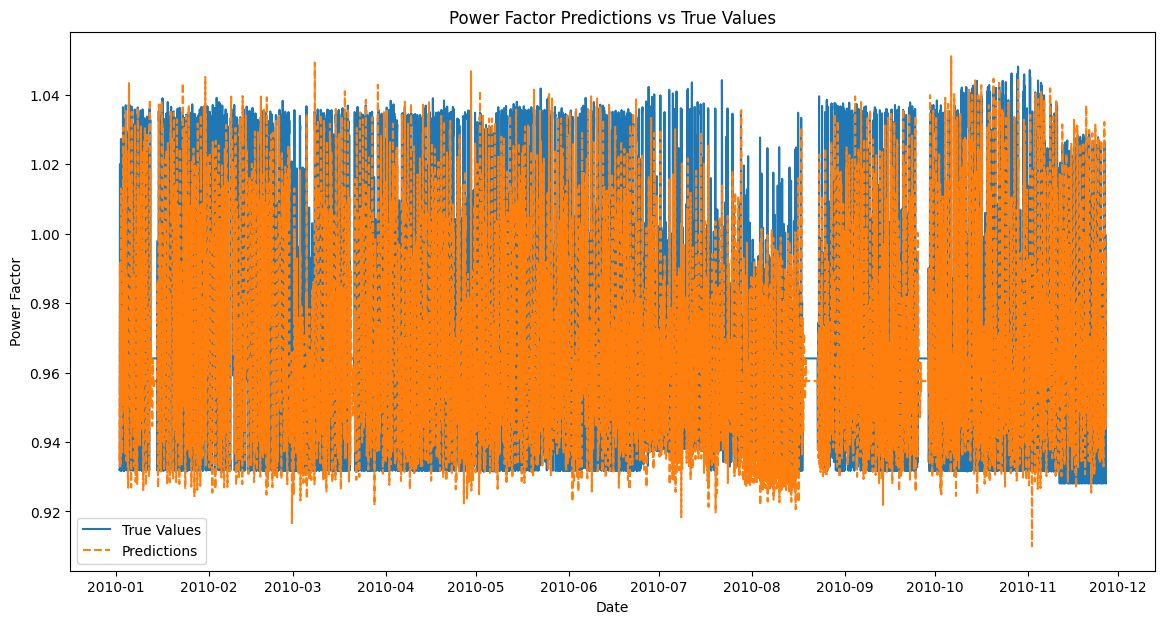

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index[-len(inv_y):], inv_y, label='True Values')
plt.plot(df_hourly.index[-len(inv_y):], inv_yhat, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Power Factor Predictions vs True Values')
plt.legend()
plt.show()

In [ ]:
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,705 (502.76 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 85,804 (335.18 KB)

Epoch 1/20
833/833 - 6s - 8ms/step - loss: 0.5131 - mean_absolute_error: 0.5439 - val_loss: 0.5265 - val_mean_absolute_error: 0.5113
Epoch 2/20
833/833 - 5s - 6ms/step - loss: 0.4476 - mean_absolute_error: 0.4907 - val_loss: 0.4924 - val_mean_absolute_error: 0.4918
Epoch 3/20
833/833 - 5s - 6ms/step - loss: 0.4189 - mean_absolute_error: 0.4656 - val_loss: 0.4577 - val_mean_absolute_error: 0.4641
Epoch 4/20
833/833 - 5s - 6ms/step - loss: 0.3910 - mean_absolute_error: 0.4405 - val_loss: 0.4447 - val_mean_absolute_error: 0.4620
Epoch 5/20
833/833 - 5s - 6ms/step - loss: 0.3687 - mean_absolute_error: 0.4214 - val_loss: 0.4404 - val_mean_absolute_error: 0.4644
Epoch 6/20
833/833 - 5s - 6ms/step - loss: 0.3549 - mean_absolute_error: 0.4112 - val_loss: 0.4291 - val_mean_absolute_error: 0.4513
Epoch 7/20
833/833 - 5s - 5ms/step - loss: 0.3409 - mean_absolute_error: 0.3990 - val_loss: 0.4189 - val_mean_absolute_error: 0.4384
Epoch 8/20
833/833 - 5s - 6ms/step - loss: 0.3303 - mean_absolute_err

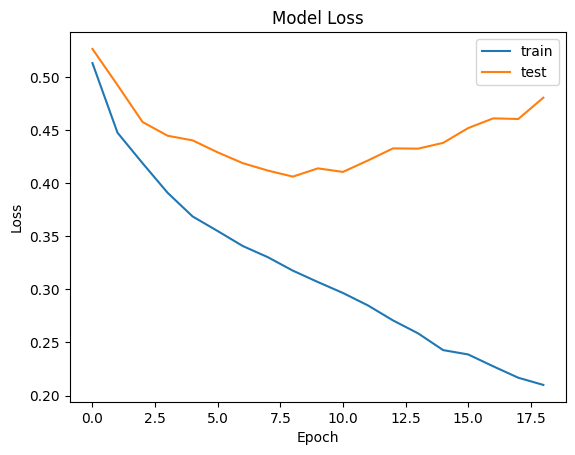

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
inv_y shape: (7894,)
inv_yhat shape: (7894,)
Test MAPE: 1.776%
Test RMSE: 0.026


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam

# Create sequences for LSTM
n_steps = 24
X_train, y_train = create_sequences(np.column_stack((y_train_raw, X_train_raw)), n_steps)
X_test, y_test = create_sequences(np.column_stack((y_test_raw, X_test_raw)), n_steps)

# Create the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, activation='tanh',
                   input_shape=(n_steps, X_train.shape[2]),
                   return_sequences=True))
model_lstm.add(LSTM(units=50,activation='tanh',
                   return_sequences=False))
model_lstm.add(Dense(1))

# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.005),
                  loss="mean_squared_error",
                  metrics=['mean_absolute_error'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                             patience=10,
                             restore_best_weights=True)

# Train the model
history_lstm = model_lstm.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=2,
    shuffle=False,
    callbacks=[early_stopping]
)

# Plot training history
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Make predictions
yhat = model_lstm.predict(X_test)

# Ensure the predicted values and test values have the same length
yhat = yhat.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(yhat), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = yhat

# Inverse transform using the original scaler
inv_yhat = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_yhat.shape)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100

print('Test MAPE: %.3f%%' % mape)
print('Test RMSE: %.3f' % rmse)

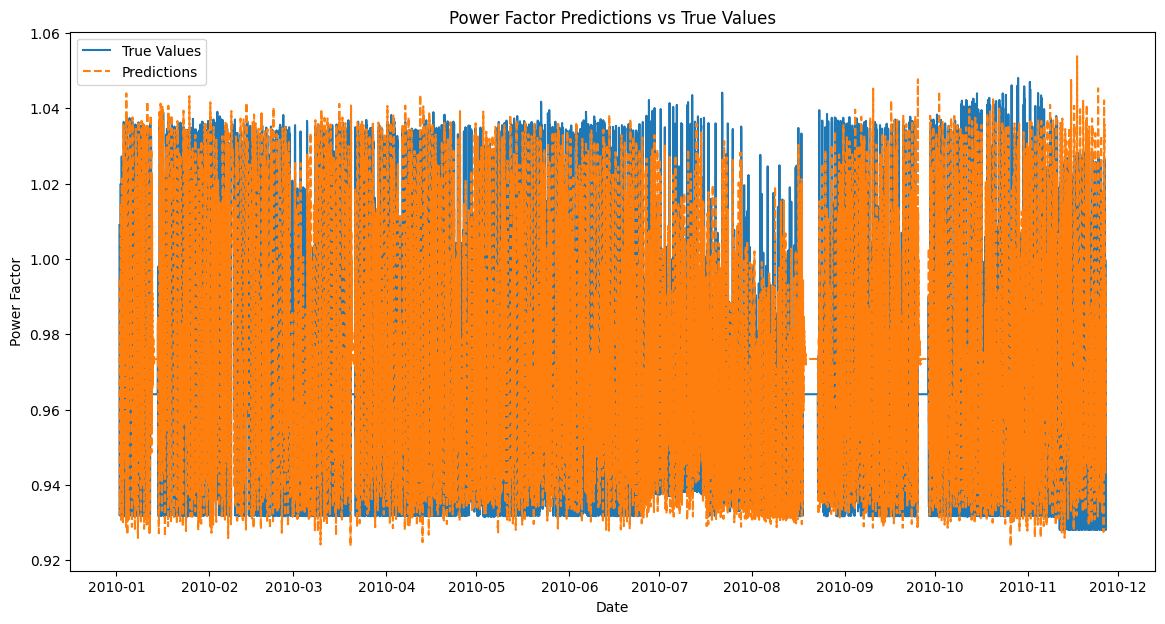

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index[-len(inv_y):], inv_y, label='True Values')
plt.plot(df_hourly.index[-len(inv_y):], inv_yhat, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Power Factor Predictions vs True Values')
plt.legend()
plt.show()

Epoch 1/10
417/417 - 3s - 7ms/step - loss: 0.5636 - mean_absolute_error: 0.5940 - val_loss: 0.5406 - val_mean_absolute_error: 0.5675
Epoch 2/10
417/417 - 2s - 4ms/step - loss: 0.4814 - mean_absolute_error: 0.5251 - val_loss: 0.5041 - val_mean_absolute_error: 0.5208
Epoch 3/10
417/417 - 2s - 4ms/step - loss: 0.4619 - mean_absolute_error: 0.5060 - val_loss: 0.4856 - val_mean_absolute_error: 0.5041
Epoch 4/10
417/417 - 2s - 4ms/step - loss: 0.4506 - mean_absolute_error: 0.4959 - val_loss: 0.4781 - val_mean_absolute_error: 0.4963
Epoch 5/10
417/417 - 2s - 4ms/step - loss: 0.4399 - mean_absolute_error: 0.4873 - val_loss: 0.4741 - val_mean_absolute_error: 0.4962
Epoch 6/10
417/417 - 2s - 4ms/step - loss: 0.4300 - mean_absolute_error: 0.4798 - val_loss: 0.4680 - val_mean_absolute_error: 0.4958
Epoch 7/10
417/417 - 2s - 4ms/step - loss: 0.4221 - mean_absolute_error: 0.4731 - val_loss: 0.4622 - val_mean_absolute_error: 0.4929
Epoch 8/10
417/417 - 2s - 4ms/step - loss: 0.4144 - mean_absolute_err

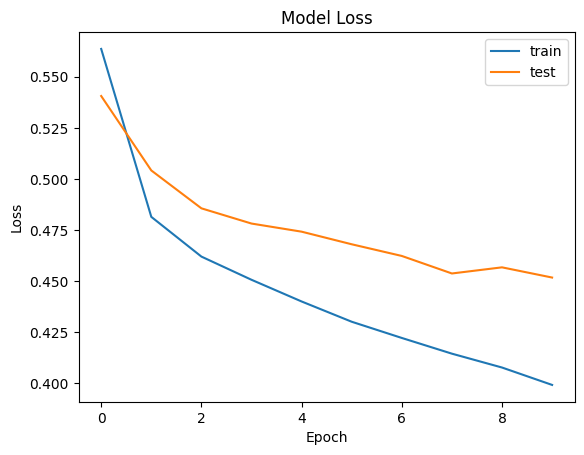

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
inv_y shape: (7888,)
inv_yhat shape: (7888,)
Test MAPE: 2.034%
Test RMSE: 0.027


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam
# Create sequences for LSTM
n_steps = 30
X_train, y_train = create_sequences(np.column_stack((y_train_raw, X_train_raw)), n_steps)
X_test, y_test = create_sequences(np.column_stack((y_test_raw, X_test_raw)), n_steps)

# Create the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, activation='tanh',
                   input_shape=(n_steps, X_train.shape[2]),
                   return_sequences=False))
model_lstm.add(Dense(1))

# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.001),
                  loss="mean_squared_error",
                  metrics=['mean_absolute_error'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                             patience=10,
                             restore_best_weights=True)

# Train the model
history_lstm = model_lstm.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    verbose=2,
    shuffle=False,
    callbacks=[early_stopping]
)

# Plot training history
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Make predictions
yhat = model_lstm.predict(X_test)

# Ensure the predicted values and test values have the same length
yhat = yhat.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(yhat), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = yhat

# Inverse transform using the original scaler
inv_yhat = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_yhat.shape)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100

print('Test MAPE: %.3f%%' % mape)
print('Test RMSE: %.3f' % rmse)

In [ ]:
# Create a DataFrame containing actual and predicted values
diff = inv_y-inv_yhat
results_df = pd.DataFrame({
    'Datetime': test_df.index[n_steps:],
    'Actual': inv_y,
    'Predicted': inv_yhat,
    'Error' : diff
})


print(results_df.sample(15))

                Datetime    Actual  Predicted     Error
2668 2010-04-23 10:00:00  1.027931   0.999802  0.028129
4203 2010-06-26 09:00:00  0.974499   0.962945  0.011553
2539 2010-04-18 01:00:00  0.933867   0.954150 -0.020283
2208 2010-04-04 06:00:00  0.931919   0.938832 -0.006913
4808 2010-07-21 14:00:00  0.937578   0.953672 -0.016094
5136 2010-08-04 06:00:00  0.937300   0.931145  0.006155
2620 2010-04-21 10:00:00  1.036558   0.963703  0.072855
7576 2010-11-13 22:00:00  1.024035   1.005367  0.018668
6512 2010-09-30 14:00:00  0.931734   0.942658 -0.010924
6731 2010-10-09 17:00:00  0.964944   1.006733 -0.041789
841  2010-02-06 07:00:00  1.034146   1.014141  0.020005
5923 2010-09-06 01:00:00  0.937207   0.937367 -0.000160
3494 2010-05-27 20:00:00  0.992959   0.976960  0.015998
6422 2010-09-26 20:00:00  0.964063   0.956612  0.007451
6849 2010-10-14 15:00:00  0.966150   1.005592 -0.039442


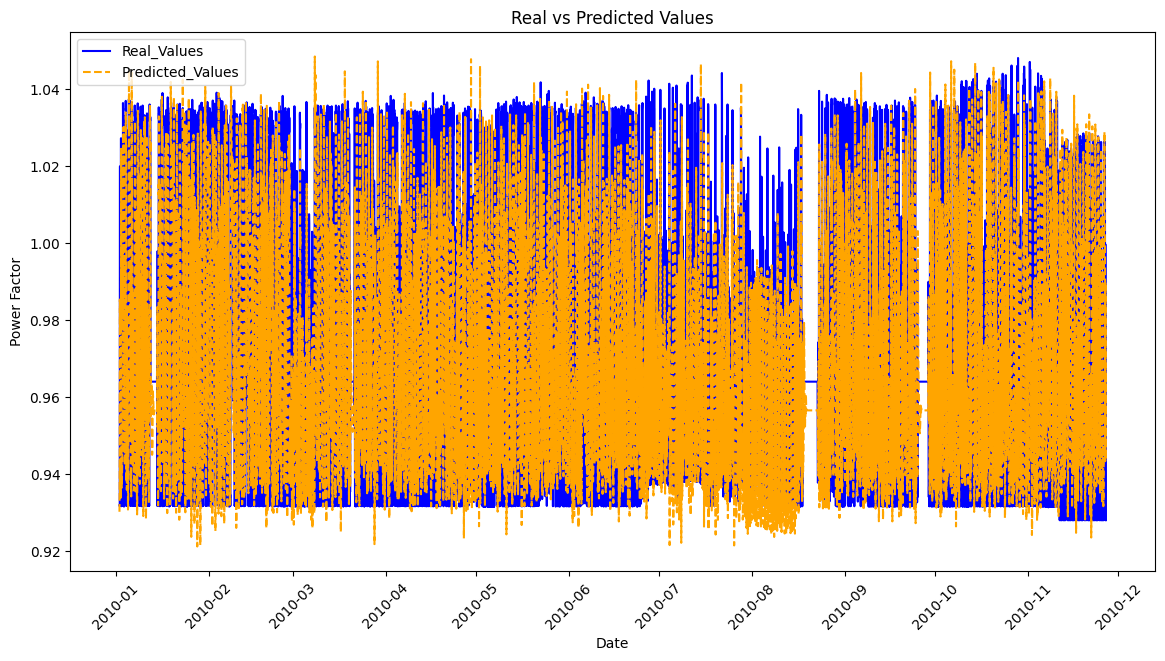

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(results_df['Datetime'], results_df['Actual'], label='Real_Values', color='blue')
plt.plot(results_df['Datetime'], results_df['Predicted'], label='Predicted_Values', linestyle='dashed', color='orange')

plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Real vs Predicted Values')
plt.legend()
plt.xticks(rotation=45)
plt.show()

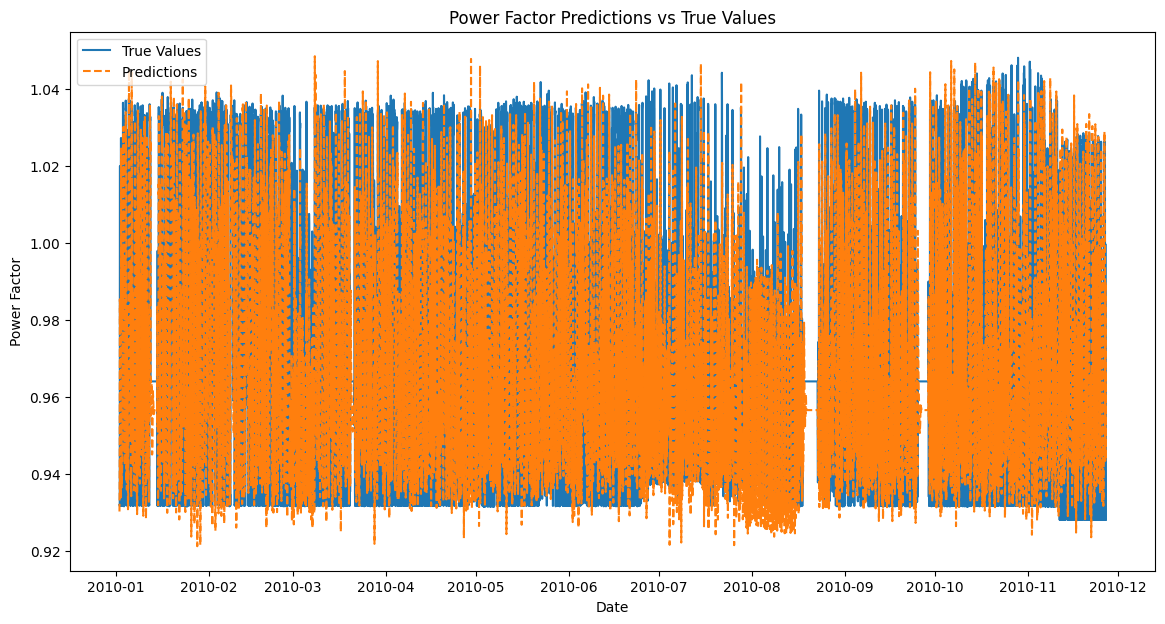

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index[-len(inv_y):], inv_y, label='True Values')
plt.plot(df_hourly.index[-len(inv_y):], inv_yhat, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Power Factor Predictions vs True Values')
plt.legend()
plt.show()

In [ ]:
model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,705 (502.76 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 85,804 (335.18 KB)

Epoch 1/20
1666/1666 - 19s - 11ms/step - loss: 0.4920 - mean_absolute_error: 0.5252 - val_loss: 0.4869 - val_mean_absolute_error: 0.4921
Epoch 2/20
1666/1666 - 15s - 9ms/step - loss: 0.4311 - mean_absolute_error: 0.4754 - val_loss: 0.4626 - val_mean_absolute_error: 0.4795
Epoch 3/20
1666/1666 - 15s - 9ms/step - loss: 0.3963 - mean_absolute_error: 0.4460 - val_loss: 0.4615 - val_mean_absolute_error: 0.4568
Epoch 4/20
1666/1666 - 15s - 9ms/step - loss: 0.3779 - mean_absolute_error: 0.4301 - val_loss: 0.4555 - val_mean_absolute_error: 0.4594
Epoch 5/20
1666/1666 - 15s - 9ms/step - loss: 0.4161 - mean_absolute_error: 0.4620 - val_loss: 0.4538 - val_mean_absolute_error: 0.4819
Epoch 6/20
1666/1666 - 15s - 9ms/step - loss: 0.3744 - mean_absolute_error: 0.4279 - val_loss: 0.4405 - val_mean_absolute_error: 0.4624
Epoch 7/20
1666/1666 - 16s - 10ms/step - loss: 0.3596 - mean_absolute_error: 0.4148 - val_loss: 0.4883 - val_mean_absolute_error: 0.4947
Epoch 8/20
1666/1666 - 15s - 9ms/step - loss: 

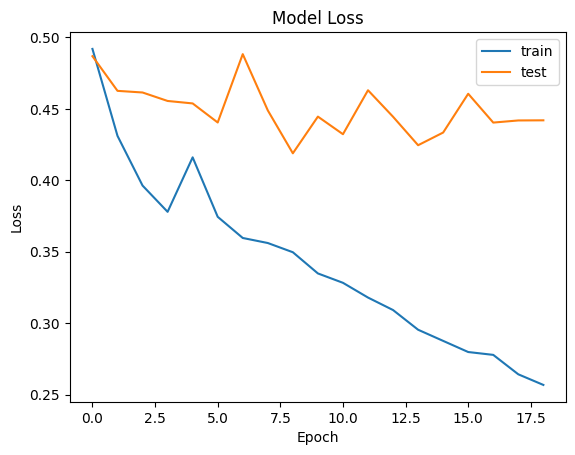

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
inv_y shape: (7894,)
inv_yhat shape: (7894,)
Test MAPE: 1.792%
Test RMSE: 0.026


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam

# Create sequences for LSTM
n_steps = 24
X_train, y_train = create_sequences(np.column_stack((y_train_raw, X_train_raw)), n_steps)
X_test, y_test = create_sequences(np.column_stack((y_test_raw, X_test_raw)), n_steps)

# Create the LSTM model
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(units=128, activation='tanh',
                   input_shape=(n_steps, X_train.shape[2]),
                   return_sequences=True)))
model_bilstm.add(Bidirectional(LSTM(units=64, activation='tanh',
                   return_sequences=False)))
model_bilstm.add(Dense(1))

# Compile the model
model_bilstm.compile(optimizer=Adam(learning_rate=0.005),
                  loss="mean_squared_error",
                  metrics=['mean_absolute_error'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                             patience=10,
                             restore_best_weights=True)

# Train the model
history_bilstm = model_bilstm.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=16,
    verbose=2,
    shuffle=False,
    callbacks=[early_stopping]
)

# Plot training history
plt.plot(history_bilstm.history['loss'])
plt.plot(history_bilstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Make predictions
yhat = model_bilstm.predict(X_test)

# Ensure the predicted values and test values have the same length
yhat = yhat.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(yhat), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = yhat

# Inverse transform using the original scaler
inv_yhat = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_yhat.shape)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100

print('Test MAPE: %.3f%%' % mape)
print('Test RMSE: %.3f' % rmse)

In [ ]:
model_bilstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 24, 256)             │         138,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 908,165 (3.46 MB)

 Trainable params: 302,721 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 605,444 (2.31 MB)

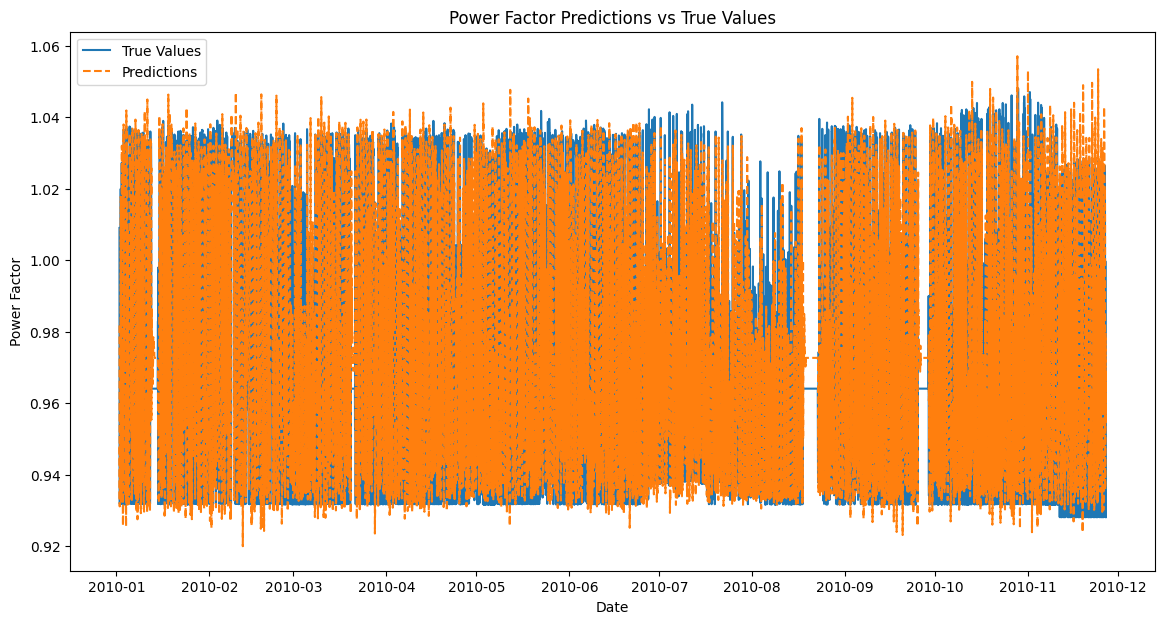

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index[-len(inv_y):], inv_y, label='True Values')
plt.plot(df_hourly.index[-len(inv_y):], inv_yhat, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Power Factor Predictions vs True Values')
plt.legend()
plt.show()

In [ ]:
# Create a DataFrame containing actual and predicted values
diff = inv_y-inv_yhat
results_df = pd.DataFrame({
    'Datetime': test_df.index[n_steps:],
    'Actual': inv_y,
    'Predicted': inv_yhat,
    'Error' : diff
})


print(results_df.sample(15))

                Datetime    Actual  Predicted     Error
6854 2010-10-14 14:00:00  1.016614   0.983237  0.033377
6804 2010-10-12 12:00:00  1.040547   0.959848  0.080699
1413 2010-03-01 21:00:00  0.931734   0.985160 -0.053426
5556 2010-08-21 12:00:00  0.964063   0.972673 -0.008610
6135 2010-09-14 15:00:00  0.937021   0.939932 -0.002911
6358 2010-09-23 22:00:00  0.937300   0.978097 -0.040797
1285 2010-02-24 13:00:00  1.032848   1.026820  0.006028
2401 2010-04-12 01:00:00  0.931827   0.939914 -0.008088
7206 2010-10-29 06:00:00  0.943515   0.925001  0.018514
709  2010-01-31 13:00:00  1.036651   0.959110  0.077541
3064 2010-05-09 16:00:00  0.944072   0.947471 -0.003400
2574 2010-04-19 06:00:00  0.999823   0.965437  0.034386
4990 2010-07-28 22:00:00  0.937578   0.931329  0.006249
4572 2010-07-11 12:00:00  0.952791   1.030829 -0.078038
3450 2010-05-25 18:00:00  0.938042   0.955401 -0.017359


###   **The results don't look bad but**<br>

In the loss graph, the blue line shows training loss, while the orange line shows test loss.
Loss values start at approximately 0.46 and decrease to around 0.025 over time, indicating that the model is learning.
There are several possible reasons for the fluctuating test loss:

- Noise in the dataset
- Learning rate might be a bit high
- Small batch size
- Model's tendency to overfit in some periods

Prediction vs True Values Graph Analysis:

- The blue line shows actual power factor values, while orange dots represent prediction.Predictions generally track the true values quite well (in the 0.95-1.00 range). More deviation is observed particularly during the 2010-07 and 2010-08 periods
The model can't fully capture sudden drops (spikes), which is normal as predicting such sudden changes is difficult

Epoch 1/20
417/417 - 7s - 17ms/step - loss: 0.5304 - mean_absolute_error: 0.5581 - val_loss: 0.5581 - val_mean_absolute_error: 0.5578
Epoch 2/20
417/417 - 4s - 9ms/step - loss: 0.4617 - mean_absolute_error: 0.5043 - val_loss: 0.5306 - val_mean_absolute_error: 0.5245
Epoch 3/20
417/417 - 4s - 9ms/step - loss: 0.4335 - mean_absolute_error: 0.4791 - val_loss: 0.4673 - val_mean_absolute_error: 0.4770
Epoch 4/20
417/417 - 4s - 9ms/step - loss: 0.4061 - mean_absolute_error: 0.4559 - val_loss: 0.4505 - val_mean_absolute_error: 0.4564
Epoch 5/20
417/417 - 4s - 9ms/step - loss: 0.3888 - mean_absolute_error: 0.4409 - val_loss: 0.4426 - val_mean_absolute_error: 0.4533
Epoch 6/20
417/417 - 4s - 10ms/step - loss: 0.3748 - mean_absolute_error: 0.4310 - val_loss: 0.4281 - val_mean_absolute_error: 0.4518
Epoch 7/20
417/417 - 4s - 9ms/step - loss: 0.3607 - mean_absolute_error: 0.4196 - val_loss: 0.4108 - val_mean_absolute_error: 0.4479
Epoch 8/20
417/417 - 4s - 9ms/step - loss: 0.3452 - mean_absolute_e

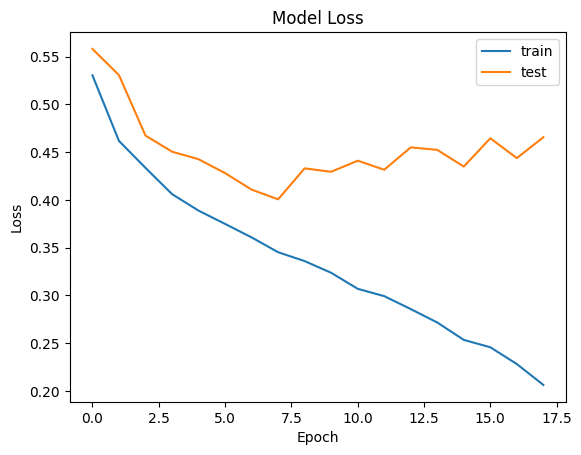

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
inv_y shape: (7894,)
inv_yhat shape: (7894,)
Test MAPE: 1.857%
Test RMSE: 0.026


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense,Dropout
from tensorflow.keras.optimizers import Adam

# Create sequences for LSTM
n_steps = 24
X_train, y_train = create_sequences(np.column_stack((y_train_raw, X_train_raw)), n_steps)
X_test, y_test = create_sequences(np.column_stack((y_test_raw, X_test_raw)), n_steps)

# Create the LSTM model
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(units=128, activation='tanh',
                   input_shape=(n_steps, X_train.shape[2]),
                   return_sequences=True)))
Dropout(0.2)
model_bilstm.add(Bidirectional(LSTM(units=64, activation='tanh',
                   return_sequences=False)))
model_bilstm.add(Dense(1))

# Compile the model
model_bilstm.compile(optimizer=Adam(learning_rate=0.003),
                  loss="mean_squared_error",
                  metrics=['mean_absolute_error'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                             patience=10,
                             restore_best_weights=True)

# Train the model
history_bilstm = model_bilstm.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=2,
    shuffle=False,
    callbacks=[early_stopping]
)

# Plot training history
plt.plot(history_bilstm.history['loss'])
plt.plot(history_bilstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Make predictions
yhat = model_bilstm.predict(X_test)

# Ensure the predicted values and test values have the same length
yhat = yhat.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(yhat), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = yhat

# Inverse transform using the original scaler
inv_yhat = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_yhat.shape)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100

print('Test MAPE: %.3f%%' % mape)
print('Test RMSE: %.3f' % rmse)

#### ***Differecence between train-test line indicates overfitting, so***

Epoch 1/20
417/417 - 8s - 18ms/step - loss: 0.8395 - mean_absolute_error: 0.5947 - val_loss: 0.5771 - val_mean_absolute_error: 0.5634
Epoch 2/20
417/417 - 4s - 9ms/step - loss: 0.5202 - mean_absolute_error: 0.5377 - val_loss: 0.5415 - val_mean_absolute_error: 0.5388
Epoch 3/20
417/417 - 4s - 10ms/step - loss: 0.4972 - mean_absolute_error: 0.5217 - val_loss: 0.5331 - val_mean_absolute_error: 0.5268
Epoch 4/20
417/417 - 4s - 10ms/step - loss: 0.4818 - mean_absolute_error: 0.5074 - val_loss: 0.5205 - val_mean_absolute_error: 0.5207
Epoch 5/20
417/417 - 4s - 10ms/step - loss: 0.4701 - mean_absolute_error: 0.4981 - val_loss: 0.5197 - val_mean_absolute_error: 0.5161
Epoch 6/20
417/417 - 4s - 9ms/step - loss: 0.4621 - mean_absolute_error: 0.4906 - val_loss: 0.5085 - val_mean_absolute_error: 0.4966
Epoch 7/20
417/417 - 4s - 9ms/step - loss: 0.4531 - mean_absolute_error: 0.4827 - val_loss: 0.4929 - val_mean_absolute_error: 0.4806
Epoch 8/20
417/417 - 4s - 9ms/step - loss: 0.4471 - mean_absolute

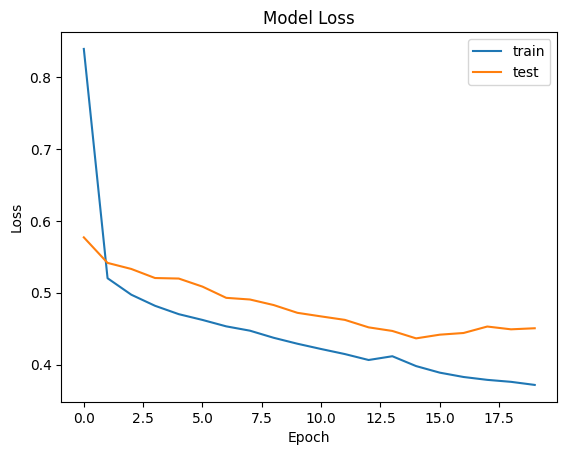

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
inv_y shape: (7894,)
inv_yhat shape: (7894,)
Test MAPE: 1.907%
Test RMSE: 0.026


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2, l1_l2

# Create sequences for LSTM
n_steps = 24
X_train, y_train = create_sequences(np.column_stack((y_train_raw, X_train_raw)), n_steps)
X_test, y_test = create_sequences(np.column_stack((y_test_raw, X_test_raw)), n_steps)

# Create the LSTM model
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(units=128, activation='tanh',
                   input_shape=(n_steps, X_train.shape[2]),
                   kernel_regularizer=l2(0.01),      # to improve measures of over-fitting
                   recurrent_regularizer=l2(0.01),   # to improve measures of over-fitting
                   return_sequences=True)))
Dropout(0.2)
model_bilstm.add(Bidirectional(LSTM(units=64, activation='tanh',
                   return_sequences=False)))
model_bilstm.add(Dense(1))

# Compile the model
model_bilstm.compile(optimizer=Adam(learning_rate=0.001),
                  loss="mean_squared_error",
                  metrics=['mean_absolute_error'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                             patience=10,
                             restore_best_weights=True)

# Train the model
history_bilstm = model_bilstm.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=2,
    shuffle=False,
    callbacks=[early_stopping]
)

# Plot training history
plt.plot(history_bilstm.history['loss'])
plt.plot(history_bilstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Make predictions
yhat = model_bilstm.predict(X_test)

# Ensure the predicted values and test values have the same length
yhat = yhat.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(yhat), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = yhat

# Inverse transform using the original scaler
inv_yhat = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_yhat.shape)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100

print('Test MAPE: %.3f%%' % mape)
print('Test RMSE: %.3f' % rmse)

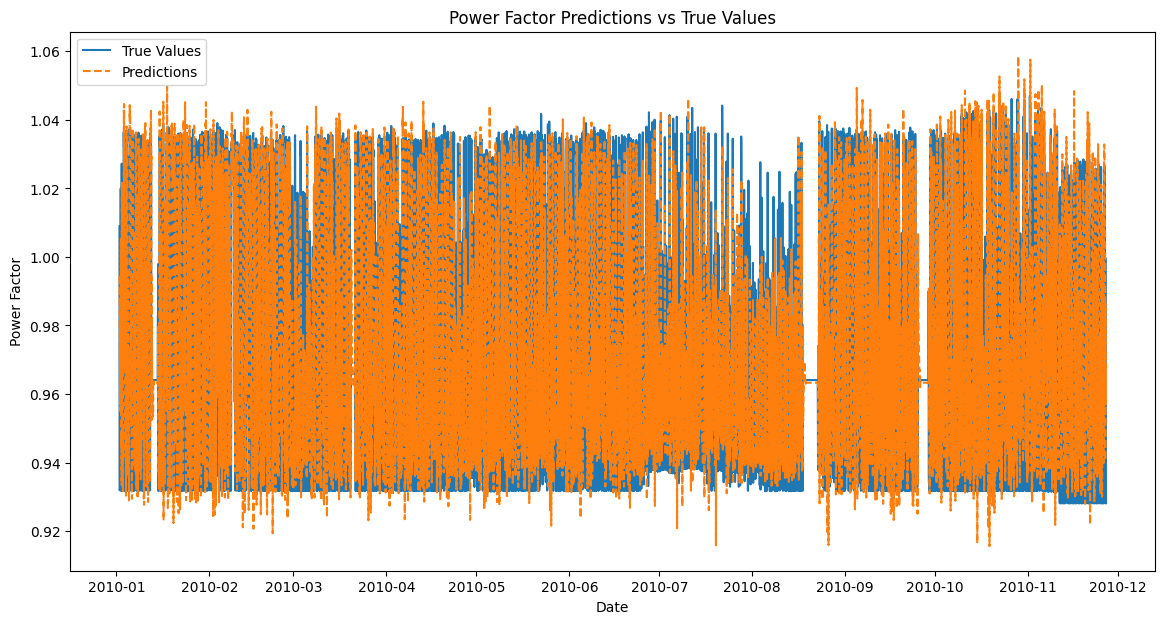

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index[-len(inv_y):], inv_y, label='True Values')
plt.plot(df_hourly.index[-len(inv_y):], inv_yhat, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Power Factor Predictions vs True Values')
plt.legend()
plt.show()

In [ ]:
model_bilstm.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional)      │ (None, 24, 256)             │         138,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 908,165 (3.46 MB)

 Trainable params: 302,721 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 605,444 (2.31 MB)

### **I think, it is enough for LSTM**

#### ***3.2.2.Gru***

##### ***_GRU (Gated Recurrent Unit) and Its Key Features_***<br><br>

GRU is a recurrent neural network (RNN) model designed to work with sequential data, widely used in tasks such as time series forecasting. Similar to LSTM, it aims to capture long-term dependencies but has a simpler structure. GRU relies on two main components: the cell state and the hidden state. Instead of separate forget, input, and output gates like LSTM, it uses only update and reset gates. This makes it more parameter-efficient, faster to train, and computationally more efficient. Compared to LSTM, it requires less memory, making it advantageous for large datasets and real-time applications. Among time series forecasting methods, it is particularly popular due to its ***high accuracy and low computational cost***.

In [ ]:
import numpy as np

def create_sequences(data, n_steps):
    """
    Creates sequences from time series data for LSTM/GRU model input.

    Parameters:
    -----------
    data : numpy array
        Input data with shape (samples, features).
        The last column is assumed to be the target variable.
    n_steps : int
        Number of time steps to look back (sequence length)

    Returns:
    --------
    X : numpy array
        Sequences with shape (samples, timesteps, features)
    y : numpy array
        Target values with shape (samples,)

    Example:
    --------
    # Assuming 'data' is your numpy array with shape (1000, 5)
    # where last column is your target variable
    X, y = create_sequences(data, n_steps=30)
    """
    X, y = [], []
    for i in range(len(data) - n_steps):
        sequence = data[i:(i + n_steps), :]
        target = data[i + n_steps, -1]  # Last column as target
        X.append(sequence)
        y.append(target)

    return np.array(X), np.array(y)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

original_columns = df_hourly.columns.tolist()

# Data preprocessing
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_hourly.reset_index(drop=True))
df_scaled = pd.DataFrame(df_scaled, columns=df_hourly.columns, index=df_hourly.index)
df_scaled['Datetime'] = df_hourly.index
df_scaled.set_index('Datetime', inplace=True)

In [ ]:
df_scaled.head(3)

voltage  global_intensity  sub_metering_1  \
Datetime                                                          
2006-12-16 17:00:00 -2.077988          3.607876       -0.319086   
2006-12-16 18:00:00 -2.099360          2.938368       -0.319086   
2006-12-16 19:00:00 -2.551344          2.644677       -0.319086   

                     sub_metering_2  sub_metering_3  power_factor  
Datetime                                                           
2006-12-16 17:00:00       -0.184969        1.424259      0.811481  
2006-12-16 18:00:00        1.300378        1.425020      0.872132  
2006-12-16 19:00:00        0.032366        1.399919      0.872329

In [ ]:
# Train-test split
train_df = df_scaled.loc[df_scaled.index < '2010-01-01 00:00:00']
test_df = df_scaled.loc[df_scaled.index >= '2010-01-01 00:00:00']

target_col = 'power_factor'
feature_cols = train_df.columns.drop([target_col])

# Prepare data for LSTM
X_train_raw = train_df[feature_cols].values
y_train_raw = train_df[target_col].values
X_test_raw = test_df[feature_cols].values
y_test_raw = test_df[target_col].values

In [ ]:
n_steps = 24
X_train, y_train = create_sequences(np.column_stack((y_train_raw, X_train_raw)), n_steps)
X_test, y_test = create_sequences(np.column_stack((y_test_raw, X_test_raw)), n_steps)

In [ ]:
# Calculating metric of WAPE Weighted Absolute Percentage Error
import tensorflow as tf
from tensorflow.keras import backend as K

def wape(y_true, y_pred):
    return K.sum(K.abs(y_true - y_pred)) / K.sum(y_true)

In [ ]:
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping


# Build the GRU model
gru_model = Sequential()
gru_model.add(GRU(100, activation='tanh', input_shape=(n_steps, X_train.shape[2])))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse',metrics=["mean_absolute_error", wape])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10,
                               restore_best_weights=True)

# Train the model with early stopping
history = gru_model.fit(X_train, y_train, epochs=20,
                        validation_data=(X_test, y_test),
                        batch_size=64,
                        callbacks=[early_stopping])

# Evaluate the model
loss = gru_model.evaluate(X_test, y_test)
print("The model creation process was completed successfully")
print("############")
print(f'Validation Loss: {loss}')

Epoch 1/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6341 - mean_absolute_error: 0.6409 - wape: 2648.5283 - val_loss: 0.5361 - val_mean_absolute_error: 0.5494 - val_wape: 18608.4844
Epoch 2/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4797 - mean_absolute_error: 0.5228 - wape: -125.4907 - val_loss: 0.5015 - val_mean_absolute_error: 0.5122 - val_wape: 23897.5410
Epoch 3/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4528 - mean_absolute_error: 0.4996 - wape: -5181.3408 - val_loss: 0.4881 - val_mean_absolute_error: 0.5032 - val_wape: 17509.8789
Epoch 4/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4464 - mean_absolute_error: 0.4948 - wape: -825.8611 - val_loss: 0.4743 - val_mean_absolute_error: 0.5128 - val_wape: 22356.2871
Epoch 5/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4366 - mean_absolute_error: 0.4870 - wape: -546.8387 - val_loss: 0.4701 - val_mean_absolute_error: 0.4996 - val_wape: 20636.0742
Epoch 6/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4

In [ ]:
# data check
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train data type:", X_train.dtype)
print("y_train data type:", y_train.dtype)

# NaN and Infinity checking
import numpy as np
print("number of X_train NaN :", np.isnan(X_train).sum())
print("number of y_train NaN :", np.isnan(y_train).sum())
print("number of X_train Infinity :", np.isinf(X_train).sum())
print("number of y_train Infinity :", np.isinf(y_train).sum())

X_train shape: (26647, 24, 6)
y_train shape: (26647,)
X_train data type: float64
y_train data type: float64
number of X_train NaN : 0
number of y_train NaN : 0
number of X_train Infinity : 0
number of y_train Infinity : 0


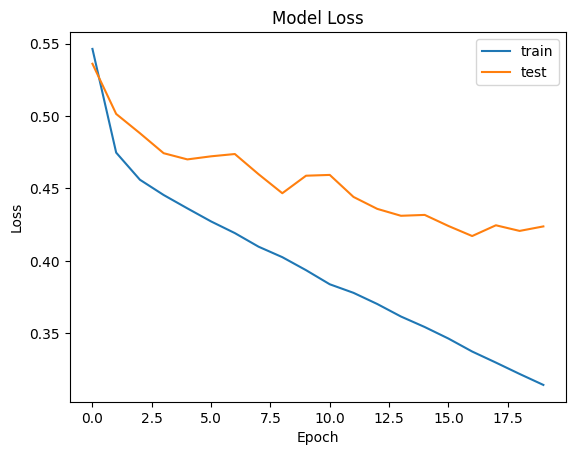

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
inv_y shape: (7894,)
inv_yhat shape: (7894,)
Test MAPE: 1.842%
Test RMSE: 0.026


In [ ]:
# Plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Make predictions
y_pred = gru_model.predict(X_test)

# Ensure the predicted values and test values have the same length
y_pred = y_pred.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(y_pred), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = y_pred

# Inverse transform using the original scaler
inv_y_pred = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_y_pred.shape)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_pred))
mape = np.mean(np.abs((inv_y - inv_y_pred) / inv_y)) * 100

print('Test MAPE: %.3f%%' % mape)
print('Test RMSE: %.3f' % rmse)

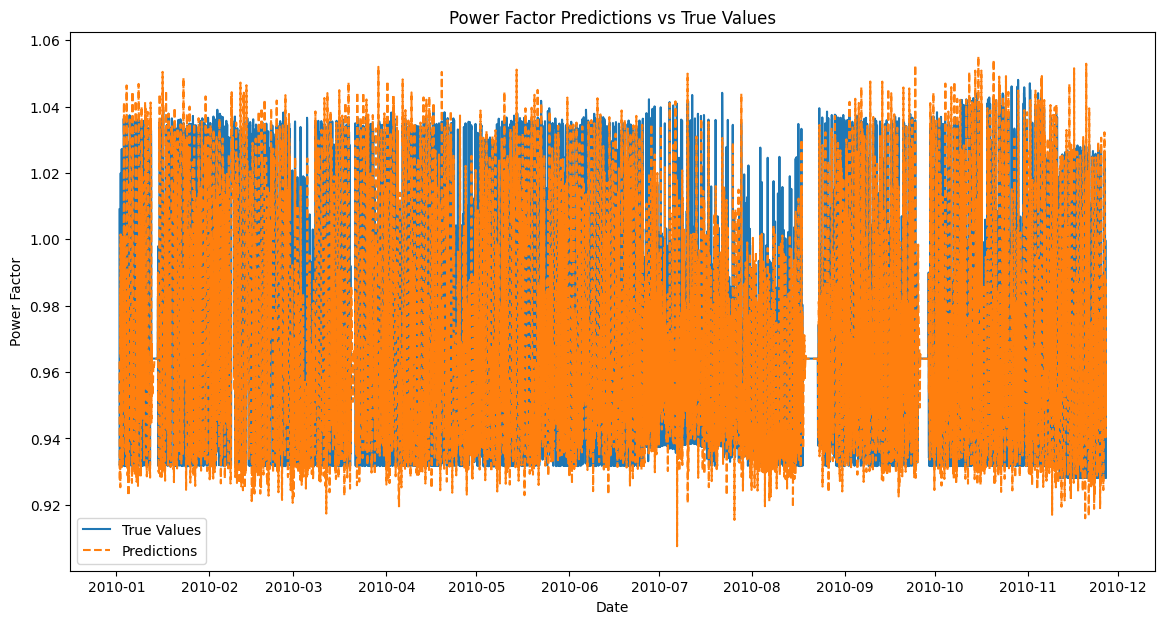

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index[-len(inv_y):], inv_y, label='True Values')
plt.plot(df_hourly.index[-len(inv_y):], inv_y_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Power Factor Predictions vs True Values')
plt.legend()
plt.show()

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


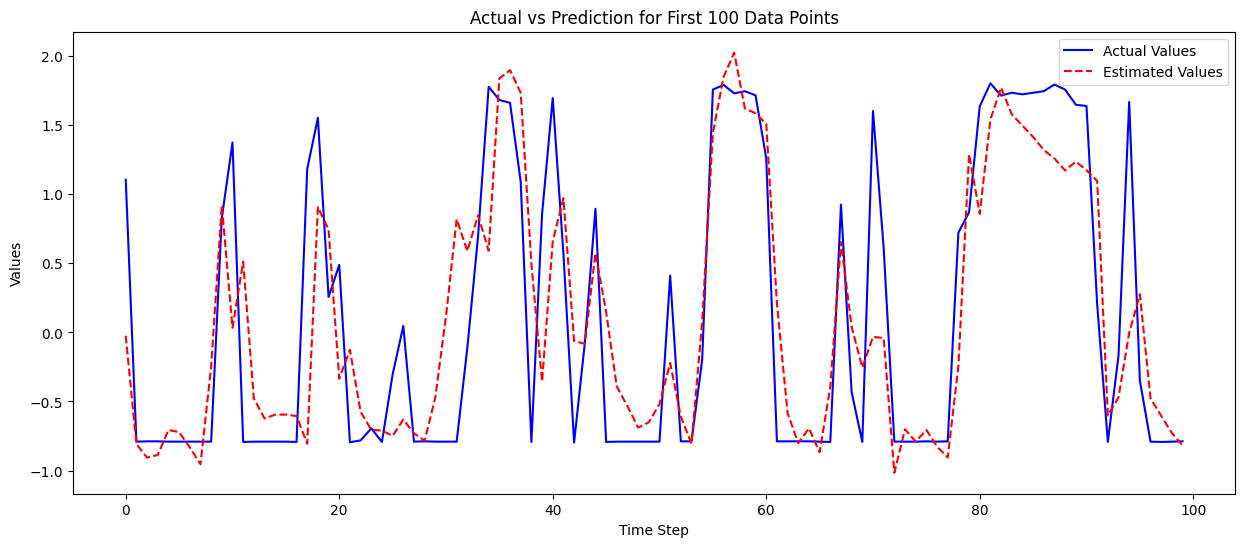

In [ ]:
y_pred = gru_model.predict(X_test)
plt.figure(figsize=(15,6))
plt.plot(y_test[:100], label='Actual Values', color='blue')
plt.plot(y_pred[:100], label='Estimated Values', color='red', linestyle='--')
plt.title('Actual vs Prediction for First 100 Data Points')
plt.xlabel('Time Step')
plt.ylabel('Values')
plt.legend()
plt.show()

Epoch 1/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 1.4641 - mean_absolute_error: 0.7148 - wape: -1021.9204 - val_loss: 0.6441 - val_mean_absolute_error: 0.6199 - val_wape: 24333.3613
Epoch 2/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.6368 - mean_absolute_error: 0.5844 - wape: -3.6741 - val_loss: 0.5637 - val_mean_absolute_error: 0.5775 - val_wape: 2467.0256
Epoch 3/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.5851 - mean_absolute_error: 0.5679 - wape: -12566.0850 - val_loss: 0.5467 - val_mean_absolute_error: 0.5591 - val_wape: 27128.7285
Epoch 4/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.5512 - mean_absolute_error: 0.5458 - wape: -6056.9204 - val_loss: 0.5275 - val_mean_absolute_error: 0.5178 - val_wape: 5879.3799
Epoch 5/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.5406 - mean_absolute_error: 0.5426 - wape: -564.9587 - val_loss: 0.5203 - val_mean_absolute_error: 0.5312 - val_wape: 8255.5312
Epoch 6/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms

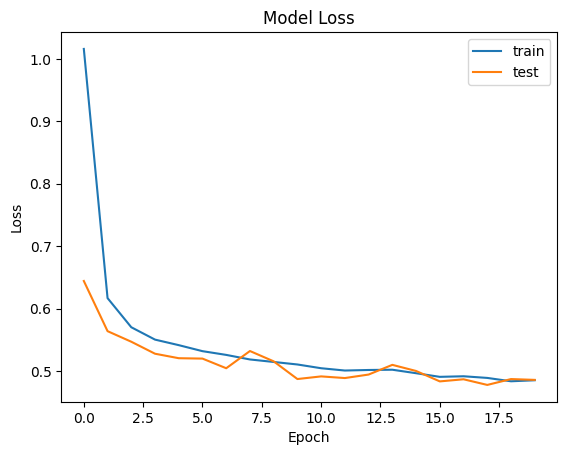

In [ ]:
from tensorflow.keras.layers import GRU, Dense,Dropout,BatchNormalization,LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam

# Build the GRU model
gru_model = Sequential()
gru_model.add(GRU(128, activation='tanh', input_shape=(n_steps, X_train.shape[2]),
                   kernel_regularizer=l2(0.01),
                   recurrent_regularizer=l2(0.01))
                   ) # to improve measures of over-fitting
gru_model.add(BatchNormalization())
gru_model.add(Dropout(0.2))
gru_model.add(Dense(64, activation=LeakyReLU(alpha=0.1)))
gru_model.add(BatchNormalization())
gru_model.add(Dropout(0.2))
gru_model.add(Dense(32, activation=LeakyReLU(alpha=0.1)))
gru_model.add(Dense(1))

gru_model.compile(optimizer=Adam(learning_rate=0.001,clipnorm=1.0),
                  loss='mse',
                  metrics=["mean_absolute_error", wape])
# clipnorm=1.0 for Gradient clipping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

# Adaptive Learning Rate
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,  # Cut your learning rate in half
#     patience=5,  # If there is no improvement for 5 epochs
#     min_lr=1e-5
# )
# Train the model with early stopping
history = gru_model.fit(X_train, y_train,
                        epochs=20,
                        validation_data=(X_test, y_test),
                        batch_size=64,
                        callbacks=[early_stopping])

# Evaluate the model
loss = gru_model.evaluate(X_test, y_test)
print("The model creation process was completed successfully ")
print("############")
print(f'Validation Loss: {loss}')

# Plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Make predictions
y_pred = gru_model.predict(X_test)

# Ensure the predicted values and test values have the same length
y_pred = y_pred.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(y_pred), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = y_pred

# Inverse transform using the original scaler
inv_y_pred = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_y_pred.shape)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_pred))
mape = np.mean(np.abs((inv_y - inv_y_pred) / inv_y)) * 100

print('Test MAPE: %.3f%%' % mape)
print('Test RMSE: %.3f' % rmse)

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
inv_y shape: (7894,)
inv_yhat shape: (7894,)
Test MAPE: 2.051%
Test RMSE: 0.027


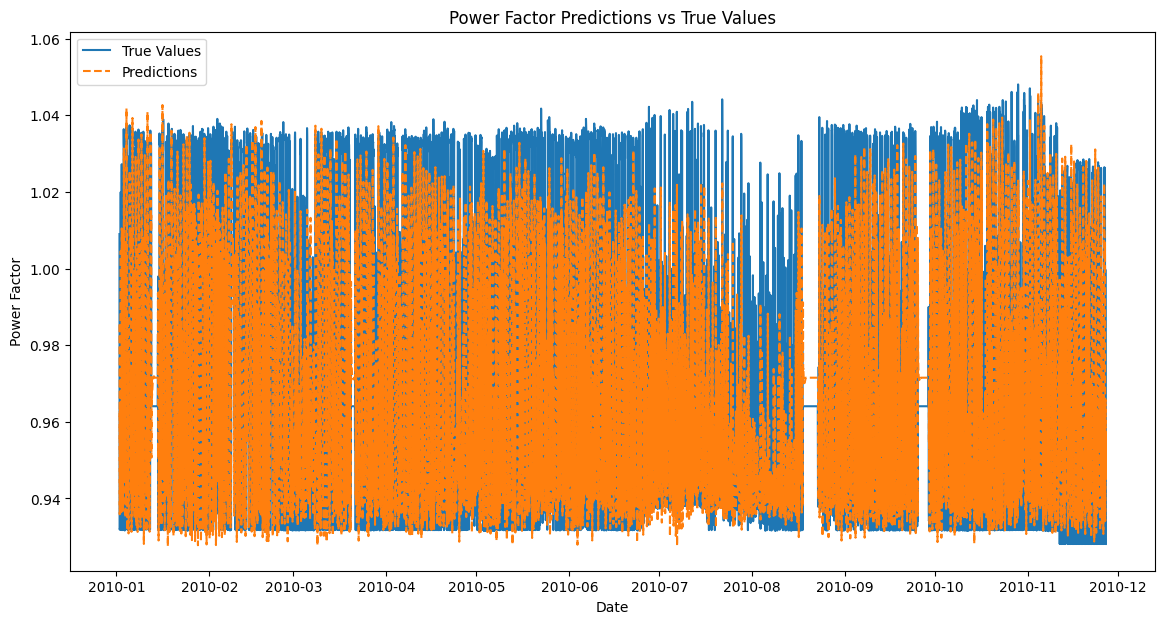

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index[-len(inv_y):], inv_y, label='True Values')
plt.plot(df_hourly.index[-len(inv_y):], inv_y_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Power Factor Predictions vs True Values')
plt.legend()
plt.show()

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


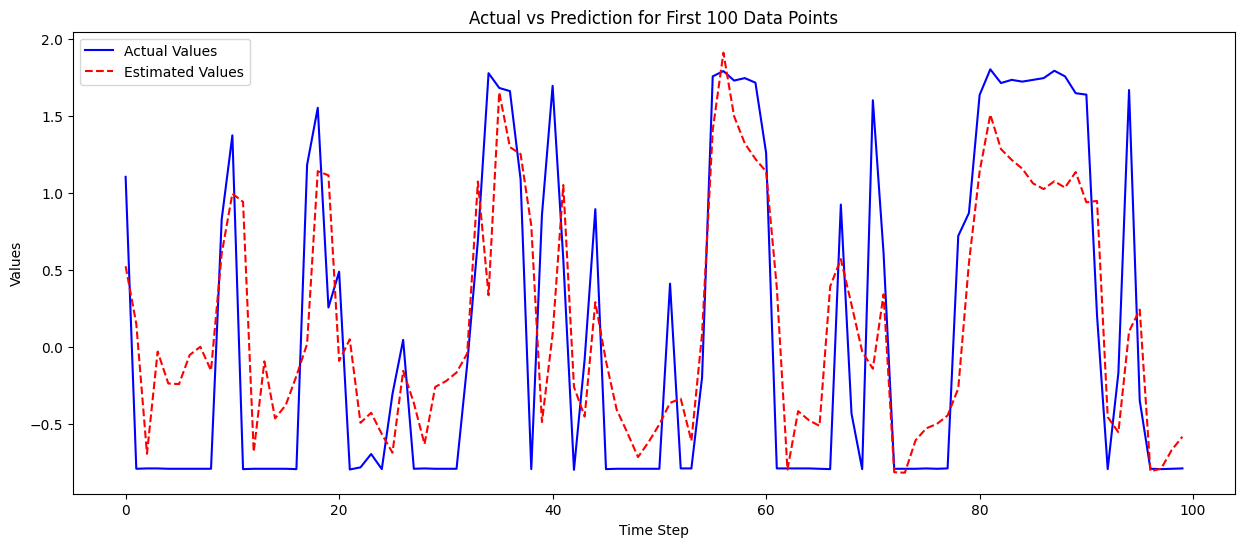

In [ ]:
y_pred = gru_model.predict(X_test)
plt.figure(figsize=(15,6))
plt.plot(y_test[:100], label='Actual Values', color='blue')
plt.plot(y_pred[:100], label='Estimated Values', color='red', linestyle='--')
plt.title('Actual vs Prediction for First 100 Data Points')
plt.xlabel('Time Step')
plt.ylabel('Values')
plt.legend()
plt.show()

Epoch 1/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 2.9873 - mean_absolute_error: 0.8300 - wape: 1750.7018 - val_loss: 1.1111 - val_mean_absolute_error: 0.5937 - val_wape: 33374.8516
Epoch 2/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.0402 - mean_absolute_error: 0.6059 - wape: -2774.9021 - val_loss: 0.7491 - val_mean_absolute_error: 0.5298 - val_wape: 46081.1055
Epoch 3/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.7565 - mean_absolute_error: 0.5849 - wape: 1387.2592 - val_loss: 0.6307 - val_mean_absolute_error: 0.5212 - val_wape: 40076.8086
Epoch 4/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.6473 - mean_absolute_error: 0.5684 - wape: 54.7904 - val_loss: 0.5852 - val_mean_absolute_error: 0.5181 - val_wape: 47501.7773
Epoch 5/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.5852 - mean_absolute_error: 0.5485 - wape: 1452.7526 - val_loss: 0.5615 - val_mean_absolute_error: 0.5313 - val_wape: 46124.7305
Epoch 6/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 4

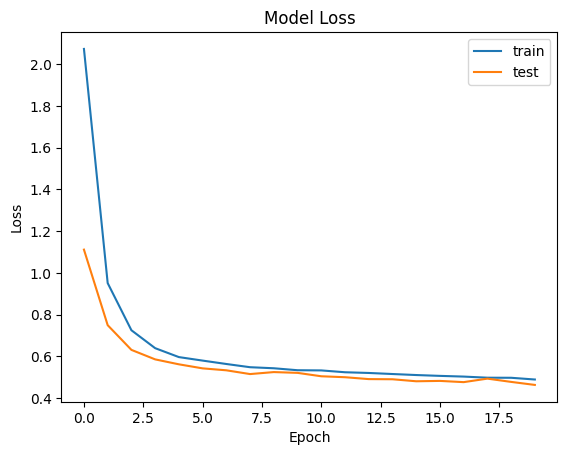

In [ ]:
from tensorflow.keras.layers import GRU, Dense,Dropout,BatchNormalization,LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import GRU, Bidirectional
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam

# Build the GRU model
bi_gru_model = Sequential()
bi_gru_model.add(Bidirectional(GRU(128, activation='tanh', input_shape=(n_steps, X_train.shape[2]),
                   kernel_regularizer=l2(0.01),
                   recurrent_regularizer=l2(0.01))
                   )) # to improve measures of over-fitting
bi_gru_model.add(BatchNormalization())
bi_gru_model.add(Dropout(0.2))
bi_gru_model.add(Dense(64, activation=LeakyReLU(alpha=0.1)))
bi_gru_model.add(BatchNormalization())
bi_gru_model.add(Dropout(0.2))
bi_gru_model.add(Dense(32, activation=LeakyReLU(alpha=0.1)))
bi_gru_model.add(Dense(1))

bi_gru_model.compile(optimizer=Adam(learning_rate=0.0003,clipnorm=1.0),
                  loss='mse',
                  metrics=["mean_absolute_error", wape])
# clipnorm=1.0 for Gradient clipping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

# Adaptive Learning Rate
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,  # Cut your learning rate in half
#     patience=5,  # If there is no improvement for 5 epochs
#     min_lr=1e-5
# )
# Train the model with early stopping
history = bi_gru_model.fit(X_train, y_train,
                        epochs=20,
                        validation_data=(X_test, y_test),
                        batch_size=64,
                        callbacks=[early_stopping])

# Evaluate the model
loss = bi_gru_model.evaluate(X_test, y_test)
print("The model creation process was completed successfully ")
print("############")
print(f'Validation Loss: {loss}')

# Plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error

# Make predictions
y_pred = bi_gru_model.predict(X_test)

# Ensure the predicted values and test values have the same length
y_pred = y_pred.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(y_pred), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = y_pred

# Inverse transform using the original scaler
inv_y_pred = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_y_pred.shape)

# Calculate metrics
mae = mean_absolute_error(inv_y, inv_y_pred)
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_pred))
mape = np.mean(np.abs((inv_y - inv_y_pred) / inv_y)) * 100

print(f"MAE: {mae:.3f}")
print(f"MAPE:  % {mape:.3f}")
print(f"RMSE: {rmse:.3f}")

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
inv_y shape: (7894,)
inv_yhat shape: (7894,)
MAE: 0.019
MAPE:  % 1.941
RMSE: 0.027


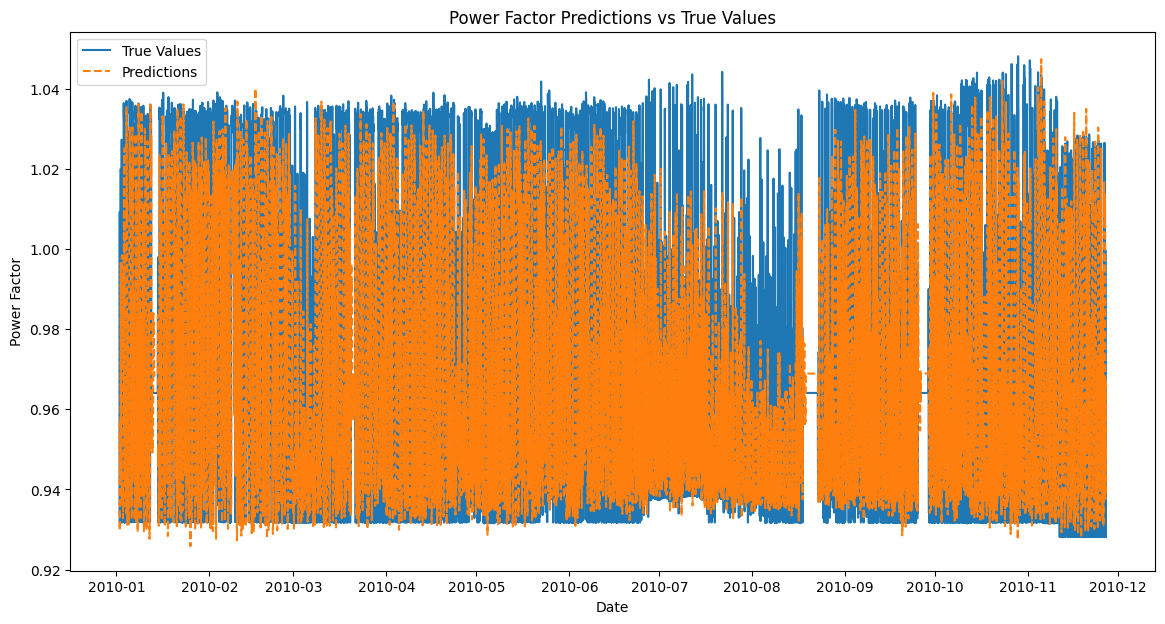

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index[-len(inv_y):], inv_y, label='True Values')
plt.plot(df_hourly.index[-len(inv_y):], inv_y_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Power Factor Predictions vs True Values')
plt.legend()
plt.show()

Epoch 1/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 5.6863 - mean_absolute_error: 0.7421 - wape: 2212.2170 - val_loss: 1.2225 - val_mean_absolute_error: 0.6083 - val_wape: 23465.0273
Epoch 2/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.0584 - mean_absolute_error: 0.6095 - wape: 1024.0326 - val_loss: 0.7055 - val_mean_absolute_error: 0.5527 - val_wape: 28620.4395
Epoch 3/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.7368 - mean_absolute_error: 0.5888 - wape: -303.5836 - val_loss: 0.6284 - val_mean_absolute_error: 0.5240 - val_wape: 35597.4336
Epoch 4/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.6678 - mean_absolute_error: 0.5777 - wape: 963.3101 - val_loss: 0.5900 - val_mean_absolute_error: 0.5597 - val_wape: 21684.3926
Epoch 5/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.6085 - mean_absolute_error: 0.5597 - wape: -234.8136 - val_loss: 0.5623 - val_mean_absolute_error: 0.5340 - val_wape: 26450.9297
Epoch 6/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 4

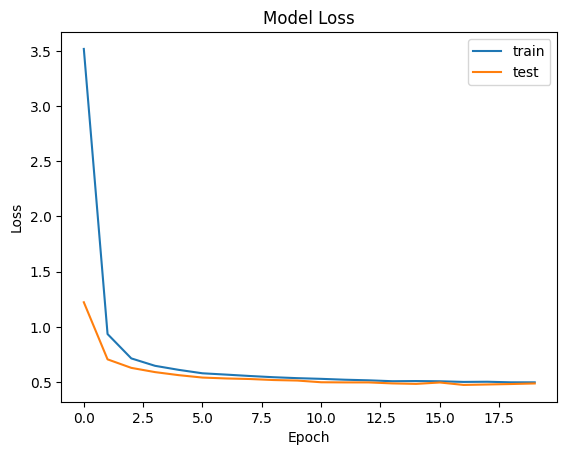

In [ ]:
from tensorflow.keras.layers import GRU, Dense,Dropout,BatchNormalization,LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import GRU, Bidirectional
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam,SGD

# Build the GRU model
bigru_model = Sequential()
bigru_model.add(Bidirectional(GRU(128, activation='tanh',
                   input_shape=(n_steps, X_train.shape[2]),
                   kernel_regularizer=l2(0.03),
                   recurrent_regularizer=l2(0.03))
                   )) # to improve measures of over-fitting
bigru_model.add(BatchNormalization())
bigru_model.add(Dropout(0.2))
bigru_model.add(Dense(64, activation="relu"))
bigru_model.add(BatchNormalization())
bigru_model.add(Dropout(0.2))
bigru_model.add(Dense(32, activation='relu'))
bigru_model.add(Dense(1))

optimizer = Adam(
    learning_rate=0.0003,
    clipnorm=1.0           # gradient clipping
)

bigru_model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=["mean_absolute_error", wape])
# clipnorm=1.0 for Gradient clipping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)


# Train the model with early stopping
history = bigru_model.fit(X_train, y_train,
                        epochs=20,
                        validation_data=(X_test, y_test),
                        batch_size=64,
                        callbacks=[early_stopping])

# Evaluate the model
loss = bigru_model.evaluate(X_test, y_test)
print("The model creation process was completed successfully ")
print("############")
print(f'Validation Loss: {loss}')

# Plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error

# Make predictions
y_pred = bigru_model.predict(X_test)

# Ensure the predicted values and test values have the same length
y_pred = y_pred.flatten()  # Convert to 1D array
y_test = y_test.flatten()

# ** Fix the inverse transform issue **

# Create an empty array for inverse transformation
dummy_data = np.zeros((len(y_pred), len(original_columns)))

# Assign predicted values to the correct column index
target_index = list(original_columns).index(target_col)
dummy_data[:, target_index] = y_pred

# Inverse transform using the original scaler
inv_y_pred = scaler.inverse_transform(dummy_data)[:, target_index]

# Do the same for actual values
dummy_data[:, target_index] = y_test
inv_y = scaler.inverse_transform(dummy_data)[:, target_index]

# Check for shape consistency before computing metrics
print("inv_y shape:", inv_y.shape)
print("inv_yhat shape:", inv_y_pred.shape)

# Calculate metrics
mae = mean_absolute_error(inv_y, inv_y_pred)
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_pred))
mape = np.mean(np.abs((inv_y - inv_y_pred) / inv_y)) * 100

print(f"MAE: {mae:.3f}")
print(f"MAPE:  % {mape:.3f}")
print(f"RMSE: {rmse:.3f}")

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
inv_y shape: (7894,)
inv_yhat shape: (7894,)
MAE: 0.020
MAPE:  % 2.070
RMSE: 0.027


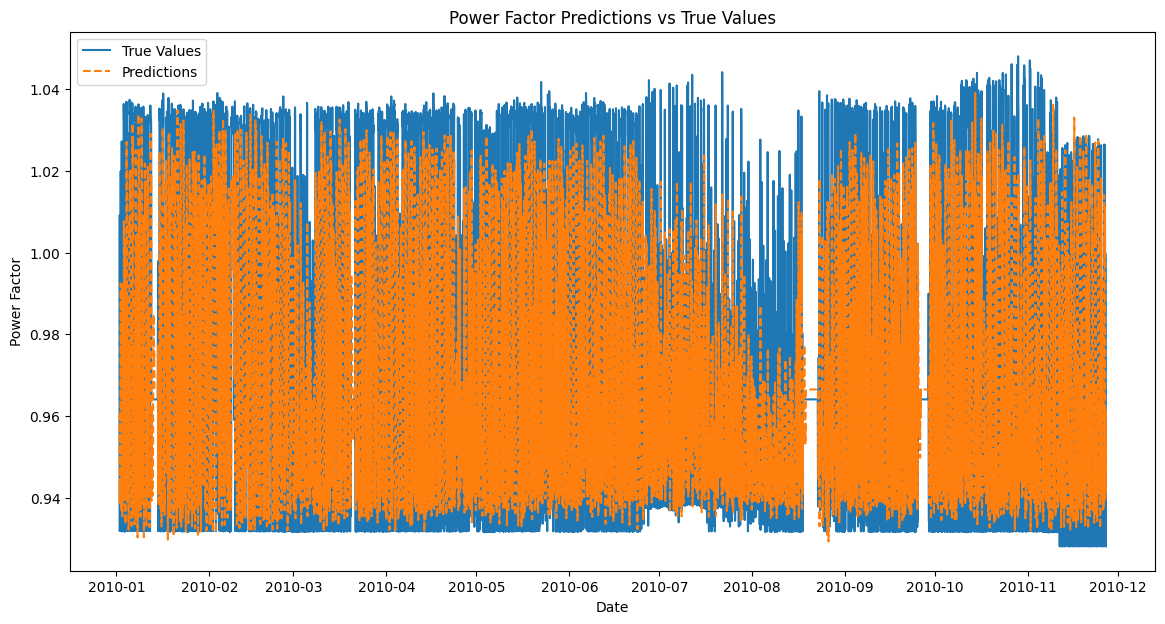

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index[-len(inv_y):], inv_y, label='True Values')
plt.plot(df_hourly.index[-len(inv_y):], inv_y_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Power Factor Predictions vs True Values')
plt.legend()
plt.show()

In [ ]:
bigru_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_7 (Bidirectional)      │ (None, 256)                 │         104,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 371,589 (1.42 MB)

 Trainable params: 123,649 (483.00 KB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 247,300 (966.02 KB)

In [ ]:
error_per = (np.abs(inv_y - inv_y_pred) / inv_y)*100
df_results = pd.DataFrame(data={"actual": inv_y[:20], "pred": inv_y_pred[:20],"error%": error_per[:20]})
df_results

actual      pred    error%
0   1.009007  0.960763  4.781393
1   0.931919  0.949959  1.935785
2   0.932012  0.938793  0.727567
3   0.932012  0.942858  1.163739
4   0.931919  0.943097  1.199466
5   0.931919  0.942669  1.153525
6   0.931919  0.945217  1.426867
7   0.931919  0.946274  1.540318
8   0.931919  0.947755  1.699238
9   0.997783  0.962416  3.544494
10  1.019953  0.992426  2.698936
11  0.931827  0.989377  6.176065
12  0.931919  0.938539  0.710342
13  0.931919  0.936664  0.509089
14  0.931919  0.940871  0.960540
15  0.931919  0.946738  1.590127
16  0.931827  0.949638  1.911410
17  1.012161  0.950645  6.077679
18  1.027232  0.989043  3.717586
19  0.974499  0.992177  1.814145

#### ***3.2.3.DeepAR(Amazon timeseries algorithm):***

For advanced time-series forecasting, Amazon Corporation developed a state-of-the-art probabilistic forecasting algorithm which is known as the Deep Autoregressive or DeepAR forecasting algorithm. This is one kind of Deep Learning model that is specifically designed to capture the inherent uncertainties associated with future predictions. Unlike traditional forecasting methods that rely on deterministic point estimates, DeepAR provides a probability distribution over future values, allowing decision-makers to assess the range of possible outcomes and make more informed decisions.
DeepAR is powerful algorithm, which has gained prominence for its effectiveness in handling complex temporal patterns and generating accurate forecasts. DeepAR is particularly well-suited for scenarios where multiple related time series need to be forecasted simultaneously, making it a valuable tool in various domains like finance, e-commerce, and supply chain management.

DeepAR is a time series forecasting model with the following key working principles:

***Autoregressive Architecture:***  DeepAR employs an autoregressive neural network architecture, where the predictions for each time step depend on a combination of historical observations and ***the model's own past predictions***. This enables the algorithm to capture more complex dependencies within the time series data, making it adept at handling sequences with intricate patterns and trends.<br>
***Embedding of Categorical Features:*** DeepAR can seamlessly incorporate information from categorical features associated with time series data. This is achieved through the use of embeddings, which transform categorical variables into continuous vectors. The inclusion of such features enhances the model's ability to discern patterns and relationships within the data, especially in scenarios where external factors influence the time series.<br>
***Temporal Attention Mechanism:*** To effectively weigh the importance of different time points in the historical data, DeepAR utilizes a temporal attention mechanism. This mechanism enables the model to focus on relevant portions of the time series, adapting its attention dynamically based on the patterns present in the data.<br>
***Training with Quantile Loss:*** DeepAR is trained using a probabilistic approach that minimizes the quantile loss. This means the model is optimized to generate prediction intervals, representing the range of possible future values with associated confidence levels. This probabilistic framework is particularly valuable in decision-making processes, providing decision-makers with a nuanced understanding of the uncertainty associated with the forecasts.

In [6]:
!pip install gluonts
!pip install "gluonts[torch]" # gluon time series library with pytorch backend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator


### ***3.3.1.Model defining***<br>

The DeepAR estimator model by defining its various hyper-parameters which are listed below--><br>

**freq:** this parameter defines the frequency of the time series data. It represents the number of time steps in one period or cycle of the time series. Our data has minute observations but due to computational time we will resample to hourly, so, the frequency is determined by the variable freq.<br>
**context_length:** This parameter sets the number of time steps that the model uses to learn patterns and dependencies in the historical data. Here it is set to (24 * 5), indicating that the model looks back over a period equivalent to 5 days (by assuming each time step corresponds to an hour).<br>
**prediction_length:** This parameter specifies how far into the future the model should generate predictions. It determines the length of the forecast horizon.<br>
**cardinality:** This parameter is a list that indicates the number of categories for each categorical feature in the dataset.
**num_layers:** It determines the number of layers in the neural network architecture. In our case, the model is configured with 2 layers.<br>
**dropout_rate:** It is a regularization technique that helps prevent overfitting. It represents the fraction of input units to drop out during training. A value of 0.25 means that 25% of the input units will be randomly set to zero during each update.<br>
**trainer_kwargs:** This is a dictionary containing additional arguments for the training process. In our case, it includes: 'max_epochs':16, which sets the maximum number of training epochs. An epoch is one complete pass through the entire training dataset.

In [ ]:
!pip install --upgrade pip
!pip install --upgrade setuptools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.6 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Uninstalling setuptools-75.1.0:
      Successfully uninstalled setuptools-75.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


In [9]:
df_hourly = df.resample('1H').mean()

In [10]:
df_hourly.index.min(),df_hourly.index.max()

(Timestamp('2006-12-16 17:00:00'), Timestamp('2010-11-26 21:00:00'))

In [11]:
df_hourly.columns

Index(['voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2',
       'sub_metering_3', 'power_factor'],
      dtype='object')

In [12]:
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.dataset.pandas import PandasDataset

freq = "1H"  # rate at which dataset is sampled
start_train = pd.Timestamp("2006-12-16 17:00:00")
start_test = pd.Timestamp("2010-01-01 00:00:00")
prediction_lentgh = 24 * 1  # Our prediction Length is 1 Day

# training and testing sets split
df_train = df_hourly.loc[df_hourly.index < '2010-01-01 00:00:00']
df_test = df_hourly.loc[df_hourly.index >= '2010-01-01 00:00:00']

# Prepare the training and testing datasets for DeepAR

# Set the target column to 'power_factor' and use other columns as features
target_col = 'power_factor'
feature_cols = ['voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']


# Training dataset
# I used PandasDataset instead of Listdataset above for correct data format,
train_ds = PandasDataset(
    df_train,
    target=target_col,
    feat_dynamic_real=feature_cols,
    freq=freq
)

# Testing dataset
#  I used PandasDataset instead of Listdataset above for correct data format
test_ds = PandasDataset(
    df_test,
    target=target_col,
    feat_dynamic_real=feature_cols,
    freq=freq
)

In [13]:
for i, data_entry in enumerate(train_ds):
    print(f"Veri girişi {i}:")
    print(data_entry)
    if i >= 5:  # It is enough to see the first few examples
        break

Veri girişi 0:
{'start': Period('2006-12-16 17:00', 'h'), 'target': array([0.99705199, 0.99951761, 0.99952564, ..., 0.99682769, 0.99641199,
       0.99695724]), 'feat_dynamic_real': array([[234.64388889, 234.58016667, 233.2325    , ..., 236.6415    ,
        237.91383333, 240.07133333],
       [ 18.1       ,  15.6       ,  14.50333333, ...,  12.1       ,
          8.52      ,   6.95666667],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.52777778,   6.71666667,   1.43333333, ...,   0.35      ,
          0.53333333,   0.        ],
       [ 16.86111111,  16.86666667,  16.68333333, ...,  18.71666667,
         17.98333333,  18.31666667]])}


In [14]:
for i, d_test_entry in enumerate(test_ds):
    print(f"Veri girişi {i}:")
    print(d_test_entry)
    if i >= 5:  # It is enough to see the first few examples
        break

Veri girişi 0:
{'start': Period('2010-01-01 00:00', 'h'), 'target': array([0.98961909, 0.97173193, 0.98150398, ..., 0.99870591, 0.99717618,
       1.        ]), 'feat_dynamic_real': array([[2.41300000e+02, 2.41620667e+02, 2.44012333e+02, ...,
        2.36741000e+02, 2.39396000e+02, 2.39690000e+02],
       [4.47666667e+00, 2.72333333e+00, 2.65333333e+00, ...,
        7.05666667e+00, 4.91333333e+00, 3.80000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.00000000e-01, 0.00000000e+00, ...,
        6.66666667e-02, 1.06666667e+00, 0.00000000e+00],
       [8.51666667e+00, 6.50000000e-01, 6.66666667e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])}


In [15]:
for i, entry in enumerate(test_ds):
    print(f"Seri {i}: Uzunluk = {len(entry['target'])}")

Seri 0: Uzunluk = 7918


In [16]:
for i, entry in enumerate(train_ds):
    print(f"Seri {i}: Uzunluk = {len(entry['target'])}")

Seri 0: Uzunluk = 26671


In [17]:
# context length is number of time steps will look back(Inspired by the value
# in the LSTM model I created above and liked the results, I set it as 24 here.)

from gluonts.torch.model.deepar import DeepAREstimator

estimator = DeepAREstimator(
    freq = freq ,  # hourly frequens
    prediction_length=prediction_lentgh,  # The number of periods we want to predict
    context_length=24*1,  # Number of periods to be used as history
    num_layers=2,  # LSTM layers
    hidden_size=40, # Number of RNN cells for each layer (default: 40)
    lr = 0.001,   # learning rate
    dropout_rate=0.1,
    patience = 10,  # Patience parameter for learning rate scheduler (default=10)
    num_feat_dynamic_real=5,  # number of features except target
    batch_size=64,
    trainer_kwargs={'max_epochs':16,"accelerator": "gpu", "devices": 1}  # use only one GPU

)

In [18]:
predictor = estimator.train(train_ds)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type        | Params | Mode  | In sizes                                                        | Out sizes   
-------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 28.4 K | train | [[1, 1], [1, 1], [1, 744, 10], [1, 744], [1, 744], [1, 24, 10]] | [1, 100, 24]
---------------------------------------------------------------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 0.33429 (best 0.33429), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.33429 (best 0.33429), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached -1.64799 (best -1.64799), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.64799 (best -1.64799), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached -2.02430 (best -2.02430), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 

In [19]:
print(type(predictor))

<class 'gluonts.torch.model.predictor.PyTorchPredictor'>


In [ ]:
import torch
torch.cuda.empty_cache()

In [20]:
import pickle

# Eğitilmiş modeli kaydetme
with open("deepar_predictor.pkl", "wb") as f:
    pickle.dump(predictor, f)

print("Predictor saved successfully!")

Predictor saved successfully!


In [21]:
# DeepAR itself provides a wide range of performance metrics like quantile loss, MAPE etc.
# Convert test data and predictions to iterator
import sys
sys.modules['mxnet'] = None

forecast_iterator, test_iterator = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100  # Monte Carlo sampling number
)

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9],num_workers=1)
agg_metrics, item_metrics = evaluator(test_iterator, forecast_iterator,num_series=None)
item_metrics

Running evaluation: 1it [00:00, 12.54it/s]


item_id    forecast_start       MSE  abs_error  abs_target_sum  \
0    None  2010-11-25 22:00  0.000187   0.253898       23.635785   

   abs_target_mean  seasonal_error     MASE      MAPE     sMAPE  \
0         0.984824        0.022279  0.47484  0.010716  0.010805   

   num_masked_target_values        ND      MSIS  QuantileLoss[0.1]  \
0                       0.0  0.010742  4.510152           0.167593   

   Coverage[0.1]  QuantileLoss[0.5]  Coverage[0.5]  QuantileLoss[0.9]  \
0            0.0           0.253898       0.083333           0.076333   

   Coverage[0.9]  
0       0.958333

In [22]:
item_metrics.T

0
item_id                               None
forecast_start            2010-11-25 22:00
MSE                               0.000187
abs_error                         0.253898
abs_target_sum                   23.635785
abs_target_mean                   0.984824
seasonal_error                    0.022279
MASE                               0.47484
MAPE                              0.010716
sMAPE                             0.010805
num_masked_target_values               0.0
ND                                0.010742
MSIS                              4.510152
QuantileLoss[0.1]                 0.167593
Coverage[0.1]                          0.0
QuantileLoss[0.5]                 0.253898
Coverage[0.5]                     0.083333
QuantileLoss[0.9]                 0.076333
Coverage[0.9]                     0.958333

In [23]:
agg_metrics

{'MSE': 0.0001867910498569422,
 'abs_error': 0.25389758425244446,
 'abs_target_sum': 23.635784652295484,
 'abs_target_mean': 0.9848243605123118,
 'seasonal_error': 0.022279241655652798,
 'MASE': 0.4748395916713955,
 'MAPE': 0.010715698821678213,
 'sMAPE': 0.010804822673698792,
 'MSIS': 4.510152134598325,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 0.16759295989330117,
 'Coverage[0.1]': 0.0,
 'QuantileLoss[0.5]': 0.25389758425244446,
 'Coverage[0.5]': 0.08333333333333333,
 'QuantileLoss[0.9]': 0.07633261286748215,
 'Coverage[0.9]': 0.9583333333333334,
 'RMSE': 0.013667152221913028,
 'NRMSE': 0.0138777560445431,
 'ND': 0.01074208400472062,
 'wQuantileLoss[0.1]': 0.007090645068854302,
 'wQuantileLoss[0.5]': 0.01074208400472062,
 'wQuantileLoss[0.9]': 0.0032295358072687804,
 'mean_absolute_QuantileLoss': 0.1659410523377426,
 'mean_wQuantileLoss': 0.0070207549602812344,
 'MAE_Coverage': 0.4583333333333334,
 'OWA': nan}

In [27]:
# View results
print("\n\033[1mAggregate Metrics:\033[0m")
for metric, value in agg_metrics.items():
    print(f"{metric}: \033[92m{value}\033[0m")

print("\n\033[1mItem Metrics:\033[0m")
for metric, value in item_metrics.items():
    print(f"{metric}: \033[92m{value}\033[0m")


Aggregate Metrics:
MSE: 0.0001867910498569422
abs_error: 0.25389758425244446
abs_target_sum: 23.635784652295484
abs_target_mean: 0.9848243605123118
seasonal_error: 0.022279241655652798
MASE: 0.4748395916713955
MAPE: 0.010715698821678213
sMAPE: 0.010804822673698792
MSIS: 4.510152134598325
num_masked_target_values: 0.0
QuantileLoss[0.1]: 0.16759295989330117
Coverage[0.1]: 0.0
QuantileLoss[0.5]: 0.25389758425244446
Coverage[0.5]: 0.08333333333333333
QuantileLoss[0.9]: 0.07633261286748215
Coverage[0.9]: 0.9583333333333334
RMSE: 0.013667152221913028
NRMSE: 0.0138777560445431
ND: 0.01074208400472062
wQuantileLoss[0.1]: 0.007090645068854302
wQuantileLoss[0.5]: 0.01074208400472062
wQuantileLoss[0.9]: 0.0032295358072687804
mean_absolute_QuantileLoss: 0.1659410523377426
mean_wQuantileLoss: 0.0070207549602812344
MAE_Coverage: 0.4583333333333334
OWA: nan

Item Metrics:
item_id: 0    None
Name: item_id, dtype: object
forecast_start: 0    2010-11-25 22:00
Name: forecast_start, dtype: period[h]
MSE:

In [28]:
import pickle


with open("deepar_item_metrics.pkl", "wb") as f:
    pickle.dump(item_metrics, f)

In [29]:
import pickle


with open("deepar_agg_metrics.pkl", "wb") as f:
    pickle.dump(agg_metrics, f)

In [30]:
import pickle

# Forecast iterator'ı kaydet
with open("forecast_iterator.pkl", "wb") as f:
    pickle.dump(list(forecast_iterator), f)

# Test iterator'ı kaydet
with open("test_iterator.pkl", "wb") as f:
    pickle.dump(list(test_iterator), f)

print("forecast_iterator ve test_iterator saved successfully!")

forecast_iterator ve test_iterator saved successfully!


In [56]:
import pandas as pd
import numpy as np
from typing import List

# First create the forecasts and test data iterators
forecast_iterator, test_iterator = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100  # Monte Carlo sampling number
)

# Convert iterators to lists to avoid consuming them
forecasts = list(forecast_iterator)
test_data = list(test_iterator)

# Initialize empty lists to store the data
timestamps = []
actual_values = []
predicted_values = []
lower_bounds = []
upper_bounds = []

# Helper function to safely get attributes, handling methods vs properties
def safe_get_attr(obj, attr_name):
    """Safely get attribute value, handling case where it might be a method"""
    try:
        attr = getattr(obj, attr_name, None)
        if attr is None:
            return None
        if callable(attr):
            return attr()  # Call the method if it's callable
        return attr  # Return the value if it's not callable
    except Exception as e:
        print(f"Error accessing {attr_name}: {e}")
        return None

# Process each forecast and test entry pair
for i, (test_entry, forecast) in enumerate(zip(test_data, forecasts)):
    # Get forecast mean safely
    forecast_mean = safe_get_attr(forecast, 'mean')
    if forecast_mean is None or len(forecast_mean) == 0:
        print(f"Warning: Forecast {i} has no mean values, skipping")
        continue

    # Get the start date and target based on test_entry type
    start_date = None
    target = None

    if isinstance(test_entry, dict):
        # Dictionary format
        start_val = test_entry.get("start")
        if start_val is not None:
            if hasattr(start_val, "to_timestamp") and callable(getattr(start_val, "to_timestamp")):
                start_date = start_val.to_timestamp(how='start')
            else:
                start_date = pd.Timestamp(start_val)
        target = test_entry.get("target", [])

    elif isinstance(test_entry, pd.DataFrame):
        # DataFrame format
        if 'start' in test_entry.columns:
            start_val = test_entry['start'].iloc[0]
            if hasattr(start_val, "to_timestamp") and callable(getattr(start_val, "to_timestamp")):
                start_date = start_val.to_timestamp(how='start')
            else:
                start_date = pd.Timestamp(start_val)
        elif isinstance(test_entry.index, pd.DatetimeIndex):
            start_date = test_entry.index[0]
        elif isinstance(test_entry.index, pd.PeriodIndex):
            start_date = test_entry.index[0].to_timestamp(how='start')

        # Get target data
        if 'target' in test_entry.columns:
            target = test_entry['target'].values
        else:
            numeric_cols = test_entry.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                target = test_entry[numeric_cols[0]].values
            else:
                target = []

    else:
        # GluonTS Entry object or other object
        start_val = safe_get_attr(test_entry, 'start')
        if start_val is not None:
            if hasattr(start_val, "to_timestamp") and callable(getattr(start_val, "to_timestamp")):
                start_date = start_val.to_timestamp(how='start')
            else:
                start_date = pd.Timestamp(start_val)

        target_val = safe_get_attr(test_entry, 'target')
        if target_val is not None:
            target = np.array(target_val)
        else:
            target = []

    # If start_date is still None, try to get it from the forecast
    if start_date is None:
        start_val = safe_get_attr(forecast, 'start_date')
        if start_val is not None:
            if hasattr(start_val, "to_timestamp") and callable(getattr(start_val, "to_timestamp")):
                start_date = start_val.to_timestamp(how='start')
            else:
                start_date = pd.Timestamp(start_val)
        else:
            # Last resort - use current time
            start_date = pd.Timestamp.now()

    # Ensure start_date has the right frequency
    try:
        if not hasattr(start_date, 'freq') or start_date.freq is None:
            start_date = start_date.to_period('H').to_timestamp(how='start')
    except Exception as e:
        print(f"Error setting frequency: {e}")
        start_date = pd.Timestamp.now().to_period('H').to_timestamp(how='start')

    # Create time range
    time_range = pd.date_range(start=start_date, periods=len(forecast_mean), freq="H")

    # Get actual values for forecast period
    if target is not None and len(target) > 0:
        if len(target) >= len(forecast_mean):
            actual_data = target[-len(forecast_mean):]
        else:
            actual_data = list(target) + [np.nan] * (len(forecast_mean) - len(target))
    else:
        actual_data = [np.nan] * len(forecast_mean)

    # Add data to lists
    timestamps.extend(time_range)
    actual_values.extend(actual_data)
    predicted_values.extend(forecast_mean)

    # Get quantiles safely
    quantiles = None
    if hasattr(forecast, 'quantiles'):
        quantiles = safe_get_attr(forecast, 'quantiles')
    elif hasattr(forecast, 'quantile'):
        quantiles = safe_get_attr(forecast, 'quantile')

    if quantiles is not None:
        # Handle different key formats
        if "0.1" in quantiles:
            lower_bounds.extend(quantiles["0.1"])
        elif 0.1 in quantiles:
            lower_bounds.extend(quantiles[0.1])
        else:
            lower_bounds.extend([None] * len(forecast_mean))

        if "0.9" in quantiles:
            upper_bounds.extend(quantiles["0.9"])
        elif 0.9 in quantiles:
            upper_bounds.extend(quantiles[0.9])
        else:
            upper_bounds.extend([None] * len(forecast_mean))
    else:
        # Try to compute from samples
        samples = safe_get_attr(forecast, 'samples')
        if samples is not None and len(samples) > 0:
            lower_bounds.extend(np.quantile(samples, 0.1, axis=0))
            upper_bounds.extend(np.quantile(samples, 0.9, axis=0))
        else:
            lower_bounds.extend([None] * len(forecast_mean))
            upper_bounds.extend([None] * len(forecast_mean))

# Create the DataFrame
if timestamps:
    predictions_df = pd.DataFrame({
        "timestamp": timestamps,
        "actual": actual_values,
        "forecast": predicted_values,
        "lower_bound": lower_bounds,
        "upper_bound": upper_bounds
    })

    # Display the first few rows of the predictions
    print(predictions_df.head(24))
else:
    print("No data was collected. Check if test_ds and predictor contain valid data.")

Error accessing quantile: SampleForecast.quantile() missing 1 required positional argument: 'q'
             timestamp    actual  forecast  lower_bound  upper_bound
0  2010-01-01 00:00:00  0.996001  0.979109     0.957283     1.006236
1  2010-01-01 01:00:00  0.978795  0.977442     0.954591     1.006691
2  2010-01-01 02:00:00  0.957529  0.948352     0.919065     0.973969
3  2010-01-01 03:00:00  0.955884  0.949233     0.923243     0.977939
4  2010-01-01 04:00:00  0.961313  0.947737     0.918512     0.974363
5  2010-01-01 05:00:00  0.959853  0.944794     0.912834     0.975269
6  2010-01-01 06:00:00  0.946559  0.950407     0.924151     0.978319
7  2010-01-01 07:00:00  0.976189  0.952891     0.924589     0.983143
8  2010-01-01 08:00:00  0.981559  0.969212     0.940852     1.000487
9  2010-01-01 09:00:00  0.998726  0.991841     0.968545     1.015527
10 2010-01-01 10:00:00  0.997642  0.999866     0.978379     1.026920
11 2010-01-01 11:00:00  0.999054  0.994337     0.975641     1.020473
12 2010

In [33]:
# CSV olarak kaydet
predictions_df.to_csv("deepar_predictions.csv", index=False)
print("Tahmin sonuçları 'deepar_predictions.csv' olarak kaydedildi.")


Tahmin sonuçları 'deepar_predictions.csv' olarak kaydedildi.


In [55]:
deepar_pred = pd.DataFrame(predictions_df)
deepar_pred.head(24)

timestamp    actual  forecast  lower_bound  upper_bound
0  2010-01-01 00:00:00  0.996001  0.976457     0.958705     0.995681
1  2010-01-01 01:00:00  0.978795  0.976437     0.955287     1.001992
2  2010-01-01 02:00:00  0.957529  0.951684     0.926935     0.977410
3  2010-01-01 03:00:00  0.955884  0.954557     0.925898     0.984425
4  2010-01-01 04:00:00  0.961313  0.950160     0.922957     0.978759
5  2010-01-01 05:00:00  0.959853  0.943589     0.917893     0.970735
6  2010-01-01 06:00:00  0.946559  0.952146     0.924487     0.984917
7  2010-01-01 07:00:00  0.976189  0.951244     0.916098     0.988962
8  2010-01-01 08:00:00  0.981559  0.970036     0.945800     0.998576
9  2010-01-01 09:00:00  0.998726  0.995655     0.967786     1.026188
10 2010-01-01 10:00:00  0.997642  0.991938     0.971878     1.010007
11 2010-01-01 11:00:00  0.999054  0.994233     0.965870     1.019286
12 2010-01-01 12:00:00  0.997280  0.992100     0.969969     1.012285
13 2010-01-01 13:00:00  0.995871  0.988688     0.969284     1.012631
14 2010-01-01 14:00:00  0.996982  0.988422     0.970011     1.015658
15 2010-01-01 15:00:00  0.990904  0.984250     0.960167     1.009871
16 2010-01-01 16:00:00  0.994902  0.989652     0.971864     1.016590
17 2010-01-01 17:00:00  0.983324  0.969968     0.945526     0.991762
18 2010-01-01 18:00:00  0.974715  0.966015     0.941345     0.989601
19 2010-01-01 19:00:00  0.998460  0.979268     0.954377     1.001490
20 2010-01-01 20:00:00  0.998358  0.975496     0.952155     1.002112
21 2010-01-01 21:00:00  0.998706  0.982095     0.954501     1.008614
22 2010-01-01 22:00:00  0.997176  0.974572     0.946131     1.002155
23 2010-01-01 23:00:00  1.000000  0.972522     0.946320     0.992758

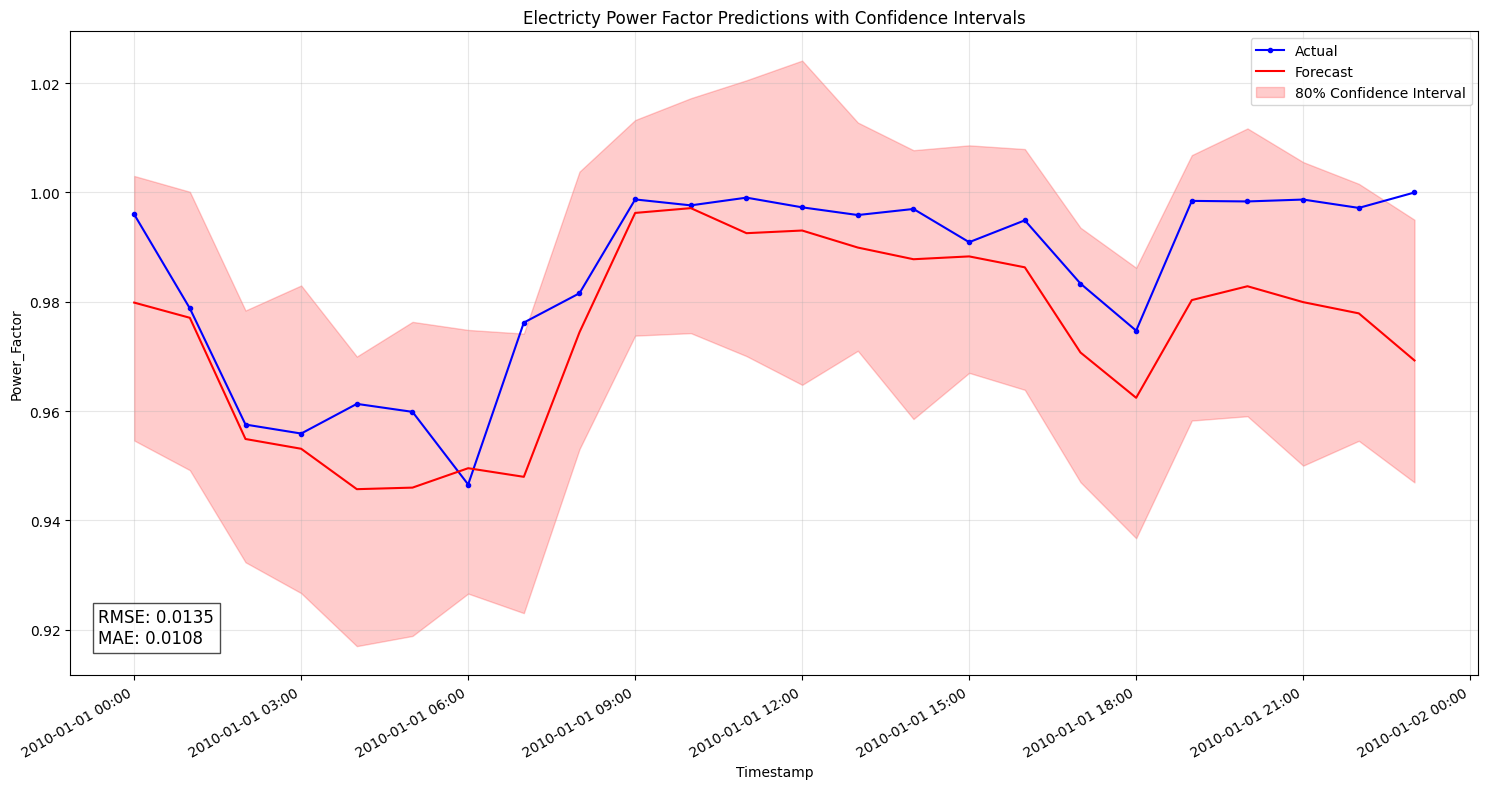

In [37]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats




# 1. VISUALIZING FORECASTS WITH CONFIDENCE INTERVALS
def plot_forecast_with_intervals(df, title="Electricty Power Factor Predictions with Confidence Intervals",
                                figsize=(15, 8), sample_size=None):
    """
    Plot the time series forecast with actual values and confidence intervals.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the forecasts with columns: timestamp, actual, forecast, lower_bound, upper_bound
    title : str
        Title of the plot
    figsize : tuple
        Figure size (width, height)
    sample_size : int, optional
        Number of data points to show (most recent). If None, show all data.
    """
    # Create a copy to avoid modifying the original
    plot_df = df.copy()

    # Set timestamp as index if it's not already
    if 'timestamp' in plot_df.columns:
        plot_df.set_index('timestamp', inplace=True)

    # Sample the most recent data points if specified
    if sample_size is not None:
        plot_df = plot_df.iloc[-sample_size:]

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # Plot actual values
    ax.plot(plot_df.index, plot_df['actual'], label='Actual', color='blue', marker='o', markersize=3, linestyle='-')

    # Plot forecast values
    ax.plot(plot_df.index, plot_df['forecast'], label='Forecast', color='red', linestyle='-')

    # Plot confidence intervals
    ax.fill_between(plot_df.index, plot_df['lower_bound'], plot_df['upper_bound'],
                    color='red', alpha=0.2, label='80% Confidence Interval')

    # Format x-axis to display dates nicely
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    fig.autofmt_xdate()

    # Add labels and legend
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Power_Factor')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Compute forecast error statistics
    mse = np.mean((plot_df['actual'] - plot_df['forecast'])**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(plot_df['actual'] - plot_df['forecast']))

    # Add text with error metrics
    ax.text(0.02, 0.05, f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}',
            transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

    plt.tight_layout()
    return fig, ax


    # Calculate grid dimensions
    n_series = len(series_ids)
    n_cols = min(2, n_series)
    n_rows = (n_series + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=True)
    if n_series == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, series_id in enumerate(series_ids):
        # Filter data for this series
        series_df = df[df[id_column] == series_id].copy()
        series_df.set_index(timestamp_col, inplace=True)

        # Plot on the corresponding subplot
        ax = axes[i]

        # Plot actual values
        ax.plot(series_df.index, series_df[actual_col], label='Actual', color='blue', marker='o', markersize=3, linestyle='-')

        # Plot forecast values
        ax.plot(series_df.index, series_df[forecast_col], label='Forecast', color='red', linestyle='-')

        # Plot confidence intervals
        ax.fill_between(series_df.index, series_df[lower_col], series_df[upper_col],
                        color='red', alpha=0.2, label='80% Confidence Interval')

        # Format x-axis
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

        # Add title and grid
        ax.set_title(f'Series: {series_id}')
        ax.grid(True, alpha=0.3)

        # Add legend to only the first subplot
        if i == 0:
            ax.legend()

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    fig.autofmt_xdate()
    return fig, axes

fig, ax = plot_forecast_with_intervals(predictions_df, sample_size=24)  # Show last 24 hours
plt.show()



# Electricity Power Factor Forecast Analysis

Here's my comment about model;

1. **Overall Performance**: Our model tracks the actual values (blue line) quite well. The RMSE of 0.0135 and MAE of 0.0108 indicate that the model's predictions are generally accurate, as these are relatively low error values.

2. **Daily Pattern**: There's a clear ***24-hour diurnal pattern*** in the electricity power factor. We can observe lower power factor values in the early morning hours (03:00-06:00), higher values during business hours (09:00-15:00), and another decline in the evening hours.

3. **Prediction Accuracy**: Our model tends to underestimate the power factor during hours with higher values (09:00-15:00). This suggests that the forecasting ***model isn't fully capturing some peak values***.

4. **Confidence Intervals**: The 80% confidence interval (pink area) generally encompasses the actual values, but at certain points (especially around 18:00), the actual value comes very close to or slightly exceeds the upper bound. This might indicate time periods with higher uncertainty.

5. **Night and Morning Hours**: The decrease in power factor during night and early morning hours (00:00-06:00) is likely due to reduced industrial or commercial loads.

6. **If I need to improve the model, maybe I will try to do the following, maybe in the future**:
   - To improve predictions during business hours (09:00-15:00), consider adding additional features (workday/holiday, seasonal factors).
   - The model structure could be reviewed to better capture sudden changes around 18:00.
   - The wider confidence intervals during certain hours indicate that prediction is more difficult during these times; separate models for these hours might be worth considering.

***Compensation and Energy Efficiency Recommendations:***
While the power factor is in good condition during business hours (09:00-15:00), adjusting reactive power compensation systems during early morning hours (03:00-06:00) can increase energy efficiency.
The sudden changes around 18:00 may be related to some industrial loads going offline, and automatic compensation systems can play a more active role during these transition periods.
Time-dependent compensation strategies can be developed for low power factor during night and morning hours.


***Cost and Penalty Analysis:*** Many electricity distribution companies impose penalties for low power factor. According to the graph, especially between 03:00-06:00 when the power factor drops below 0.95, potential penalties may be incurred during these hours. Your model can help predict these penalties and take preventive measures.

Overall, our model appears successful at capturing the daily fluctuations in power factor. The ***low error metrics*** suggest that the model is sufficiently accurate for practical applications.